In [4]:
import pandas as pd
import numpy as np
import glob
import json
import requests
import os
from understatapi import UnderstatClient
from bs4 import BeautifulSoup as bs
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
import mplcursors as mpc

### What is FPL football?

FPL is a game that casts you in the role of a Fantasy manager of Premier League players. You must pick a squad of 15 players from the 2022/23 Premier League, who score points for your team based on their performances for their clubs in PL matches.

### Why FPL football?

I'm a passionate footy fan and just as keen about data. In this EDA, I will explore this dataset that I have pre-wrangled in hopes of drawing insight about player and team performances as well as the highlighting the levers that drive manager selection of players. 

I chose to explore the 2018/19 fpl season's data as this is the year when I become a keen fpl player. If I'm correct, I remember earning a season total of 757 fpl points. Which I think is pretty decent for the a noob that I was.
This EDA will explore some simple connections between player performance, value and selection and provide summarys of performances for the hottest fpl talent for the end of the season.

FYI... If you are keen on seeing my data wrangling efforts to put together this dataset, this will also be available on github.

### Honourable mentions

Much appreciation to Vaastav Anand (https://github.com/vaastav) for the majority of the scraped data. As well as the API made available by Understat! (https://pypi.org/project/understatapi/)

In [5]:
#create operating system '(os)' file paths in variables to store all files for this project
folder_name = 'football_data'
cwd = os.getcwd()

In [6]:
fpl_pos = pd.read_csv(cwd+'\\'+folder_name+'\\'+'fpl_non_doop.csv')

In [7]:
fpl_pos.shape

(16926, 57)

In [8]:
fpl_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16926 entries, 0 to 16925
Data columns (total 57 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   first_name                       16926 non-null  object 
 1   last_name                        16926 non-null  object 
 2   full_name                        16926 non-null  object 
 3   Position                         16926 non-null  object 
 4   player_id                        16926 non-null  int64  
 5   assists                          16926 non-null  int64  
 6   goals_conceded                   16926 non-null  int64  
 7   goals_scored                     16926 non-null  int64  
 8   winning_goals                    16926 non-null  int64  
 9   big_chances_created              16926 non-null  int64  
 10  big_chances_missed               16926 non-null  int64  
 11  key_passes                       16926 non-null  int64  
 12  own_goals         

In [9]:
fpl_pos.sample(10)

first_name             last_name                   full_name Position  \
3517     Ademola               Lookman             Ademola Lookman      MID   
1032      Helder                 Costa                Helder Costa      MID   
3622       David  Luiz Moreira Marinho  David Luiz Moreira Marinho      DEF   
4212      Kadeem                Harris               Kadeem Harris      MID   
11433    Etienne                Capoue              Etienne Capoue      MID   
5860       Elias              Kachunga              Elias Kachunga      FWD   
16449     Stuart             Armstrong            Stuart Armstrong      MID   
12744   Fernando             Luiz Rosa          Fernando Luiz Rosa      MID   
9321      Ashley                 Young                Ashley Young      DEF   
5657        Ryan            Fredericks             Ryan Fredericks      DEF   

       player_id  assists  goals_conceded  goals_scored  winning_goals  \
3517         170        0               0             0              0   
1032         435        0               1             0              0   
3622         116        0               4             0              0   
4212         535        0               0             0              0   
11433        389        0               4             0              0   
5860         212        0               0             0              0   
16449        345        0               1             0              0   
12744        272        0               0             0              0   
9321         293        0               2             0              0   
5657         408        0               0             0              0   

       big_chances_created  ...  loaned_out  fixture  opponent_team  \
3517                     0  ...           0      234             10   
1032                     0  ...           0      184              9   
3622                     0  ...           0      232              2   
4212                     0  ...           0      243              2   
11433                    0  ...           0      380             19   
5860                     0  ...           0      274             20   
16449                    0  ...           0      154              5   
12744                    0  ...           0       54              5   
9321                     0  ...           0      306             13   
5657                     0  ...           0      270              9   

       team_a_score_x  team_h_score_x  was_home               team_title  \
3517                1               0     False                  Everton   
1032                1               1     False  Wolverhampton Wanderers   
3622                0               4     False                  Chelsea   
4212                0               2      True                  Cardiff   
11433               4               1      True                  Watford   
5860                0               1      True             Huddersfield   
16449               0               1     False              Southampton   
12744               5               0     False          Manchester City   
9321                2               0      True        Manchester United   
5657                1               3      True                 West Ham   

       team_strength              opp_team  opp_strength  
3517               3          Huddersfield             1  
1032               3                Fulham             2  
3622               5           Bournemouth             3  
4212               2           Bournemouth             3  
11433              3              West Ham             3  
5860               2  Wolverhampton Wolves             1  
16449              3               Cardiff             2  
12744              5               Cardiff             2  
9321               4       Manchester City             5  
5657               3                Fulham             2  

[10 rows x 57 columns]

In [10]:
#increase the dataframes viewport
pd.set_option('display.max_columns',85)

In [11]:
fpl_pos.head()

first_name    last_name          full_name Position  player_id  assists  \
0      Aaron    Cresswell    Aaron Cresswell      DEF        402        0   
1      Aaron       Lennon       Aaron Lennon      MID         83        0   
2      Aaron         Mooy         Aaron Mooy      MID        199        0   
3      Aaron       Ramsey       Aaron Ramsey      MID         14        0   
4      Aaron  Wan-Bissaka  Aaron Wan-Bissaka      DEF        145        1   

   goals_conceded  goals_scored  winning_goals  big_chances_created  \
0               0             0              0                    0   
1               0             0              0                    0   
2               3             0              0                    0   
3               1             0              0                    0   
4               0             0              0                    1   

   big_chances_missed  key_passes  own_goals  clean_sheets  \
0                   0           0          0             0   
1                   1           0          0             1   
2                   0           1          0             0   
3                   0           1          0             0   
4                   0           1          0             1   

   clearances_blocks_interceptions  completed_passes  errors_leading_to_goal  \
0                                0                 0                       0   
1                                1                17                       0   
2                                2                40                       0   
3                                0                 7                       0   
4                               11                19                       0   

   fouls  penalties_conceded  penalties_missed  penalties_saved  saves  \
0      0                   0                 0                0      0   
1      1                   0                 0                0      0   
2      1                   0                 0                0      0   
3      0                   0                 0                0      0   
4      0                   0                 0                0      0   

   tackled  tackles  target_missed  recoveries  minutes  offside  \
0        0        0              0           0        0        0   
1        1        2              0           2       90        0   
2        1        6              0          11       90        0   
3        0        2              0           1       53        2   
4        2        0              0           7       90        0   

   open_play_crosses  dribbles  red_cards  yellow_cards  creativity  ea_index  \
0                  0         0          0             0         0.0         0   
1                  1         0          0             0        12.3         0   
2                  0         1          0             0        18.2         0   
3                  0         1          0             0        10.8         0   
4                  0         2          0             0        14.0         0   

   ict_index  influence  threat  bps  bonus  total_points  value  selected  \
0        0.0        0.0       0    0      0             0     55    103396   
1        3.9       10.0      17    6      0             3     50     15138   
2        3.8       20.2       0   24      0             2     55    192110   
3        2.9        9.4       9    7      0             1     75     60423   
4        6.0       46.0       0   38      3            12     40    652304   

   transfers_balance  transfers_in  transfers_out  gw  loaned_in  loaned_out  \
0                  0             0              0   1          0           0   
1                  0             0              0   1          0           0   
2                  0             0              0   1          0           0   
3                  0             0              0   1          0           0   
4                  0             0              

In [12]:
fpl_pos.selected.describe()

count    1.692600e+04
mean     1.852375e+05
std      3.856892e+05
min      0.000000e+00
25%      8.683000e+03
50%      3.536550e+04
75%      1.636235e+05
max      3.191635e+06
Name: selected, dtype: float64

In [13]:
fpl_values = fpl_pos.selected.describe()

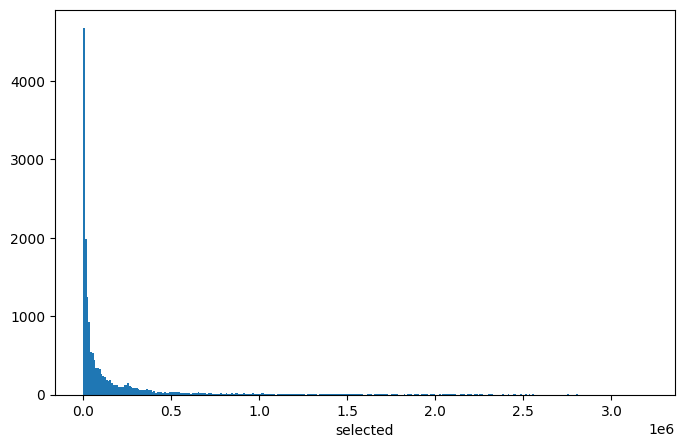

In [14]:
#view distribution of selection values
binsize = 10000
bins = np.arange(0, fpl_pos['selected'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = fpl_pos, x = 'selected', bins = bins)
plt.xlabel('selected')
plt.show()

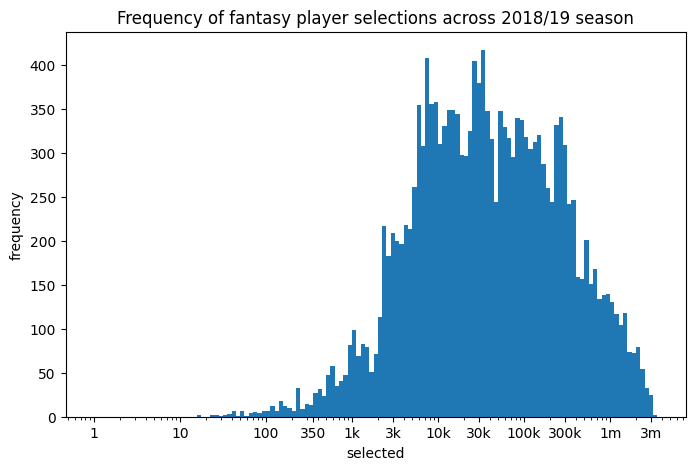

In [15]:
# start with a standard-scaled plot
binsize = 0.05
bins = 10 ** np.arange(0, np.log10(fpl_pos['selected'].max())+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = fpl_pos, x = 'selected', bins = bins)
plt.xlabel('selected')
plt.ylabel('frequency')
plt.xscale('log')
plt.xticks([1, 10, 100, 350, 1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6], 
           [1, 10, 100, 350, '1k', '3k', '10k', '30k', '100k', '300k','1m', '3m'])
plt.title('Frequency of fantasy player selections across 2018/19 season')
plt.show()

Player selection has a long-tail distribution, with most players with less than 300k selections per gameweek while a few 'high-profile' players with selections north 300k and even fewer with millions of gameweek selections. 
When plotted on a log-scale, the selection distribution looks roughly guassian; the highest peak at about 50k gameweek selections.
Player selections are a tactical decision. With over 8million weekly fpl players, and up to 500 premier league footballers to pick from. Player selection is a vote of confidence of the footballers ability to perform and earn the fpl player points. 
A selection of 500k users is a 1/18 vote that the footballer will perform.

In [16]:
fpl_pos.value.describe()

count    16926.000000
mean        52.838946
std         13.473670
min         38.000000
25%         45.000000
50%         49.000000
75%         56.000000
max        136.000000
Name: value, dtype: float64

In [17]:
fpl_values = fpl_pos.value.describe()
fpl_val_max = fpl_values[7]
fpl_val_75 = fpl_values[6]
fpl_val_mean = fpl_values[1]

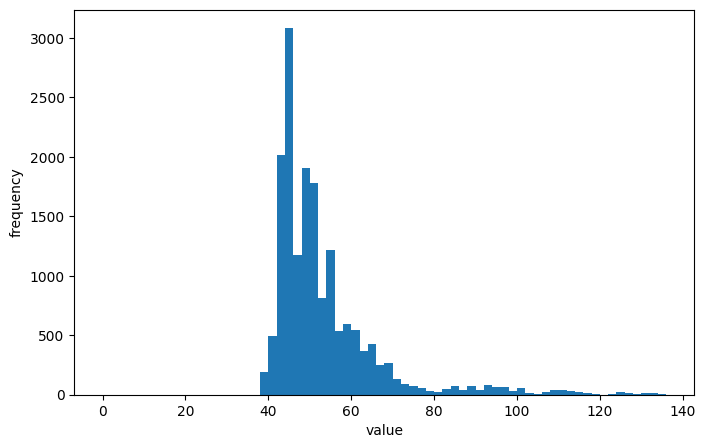

In [18]:
# 
binsize = 2
bins = np.arange(0, fpl_pos['value'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = fpl_pos, x = 'value', bins = bins)
plt.xlabel('value')
plt.ylabel('frequency')
plt.show()

Player value also has a long-tail distribution. A log of the distribution yields no key insights. Most players are valued between 40 - 60 in fpl millions. I will consider football players with values above the 75% percentile as high value players. I set the value at 60 fpl millions to make it a clean cut off in value.

I will also explore to see if there is a correlation between the value of a player and the players gameweek selection.

In [19]:
high_value = fpl_pos.query('value >= 60')

In [20]:
#list of players who's value is equal to or above 60 fantasy million bucks
high_value.full_name.value_counts().index.tolist()

['Aaron Ramsey',
 'Kyle Walker',
 'Marko Arnautovic',
 'Marcus Rashford',
 'Marcos Alonso',
 'Manuel Lanzini',
 'Luka Milivojevic',
 'Lucas Moura da Silva',
 'Lucas Perez',
 'Leroy Sane',
 'Kieran Trippier',
 'Michail Antonio',
 'Kevin De Bruyne',
 'Juan Mata',
 'Joshua King',
 'Jesse Lingard',
 'Jamie Vardy',
 'James Maddison',
 'Heung-Min Son',
 'Henrikh Mkhitaryan',
 'Mesut Ozil',
 'Mohamed Elyounoussi',
 'Gylfi Sigurdsson',
 'Riyad Mahrez',
 'Alvaro Morata',
 'Xherdan Shaqiri',
 'Wilfried Zaha',
 'Sergio Aguero',
 'Sadio Mane',
 'Ryan Sessegnon',
 'Romelu Lukaku',
 'Roberto Firmino',
 'Richarlison de Andrade',
 'Mohamed Salah',
 'Raheem Sterling',
 'Pierre-Emerick Aubameyang',
 'Pedro Rodriguez Ledesma',
 'Paul Pogba',
 'Pascal Gross',
 'Olivier Giroud',
 'Nicolas Otamendi',
 'Naby Keita',
 'Harry Kane',
 'Junior Stanislas',
 'Glenn Murray',
 'Cesar Azpilicueta',
 'Christian Eriksen',
 'Christian Benteke',
 'Cesc Fabregas',
 'Cenk Tosun',
 'Callum Wilson',
 'Benjamin Mendy',
 'Gabr

In [21]:
#some high value players have 38 rows of data, each row representing a matchweek
high_value.full_name.value_counts()

Aaron Ramsey         38
Kyle Walker          38
Marko Arnautovic     38
Marcus Rashford      38
Marcos Alonso        38
                     ..
Danny Rose            2
Manolo Gabbiadini     2
Fernando Llorente     1
Chris Smalling        1
Yannick Bolasie       1
Name: full_name, Length: 116, dtype: int64

In [22]:
high_val_players = high_value.groupby(['full_name']).agg(selected_avg=('selected', np.mean), value_avg =('value',np.mean), total_points =('total_points',np.sum), total_minutes =('minutes',np.sum)).sort_values(['selected_avg'],ascending=False)

In [23]:
high_val_players

selected_avg   value_avg  total_points  total_minutes
full_name                                                                     
Mohamed Salah            2.464299e+06  131.815789           259           3254
Sergio Aguero            2.284724e+06  114.526316           201           2457
Marcos Alonso            2.103470e+06   66.763158           161           2759
Andrew Robertson         1.938355e+06   65.447368           213           3216
Eden Hazard              1.915501e+06  109.710526           238           2918
...                               ...         ...           ...            ...
Junior Stanislas         4.804842e+03   60.000000            56           1021
Manuel Lanzini           4.449500e+03   64.078947            31            685
Dwight Gayle             3.686158e+03   60.000000             0              0
Alex Oxlade-Chamberlain  2.305737e+03   64.131579             2             19
Isaac Mbenza             9.013750e+02   60.000000             4             84

[116 rows x 4 columns]

### Initial feature engineering

Categories

- Team status (top six - 1/6, european challengers 7/9, mid table - 10/14, limbo, newly promoted)
- Team challenge - chance of beating opposition team
- Goal type scored
- Goals scored vs opposition

Set team status

In [24]:
team_name = [
    (fpl_pos['team_title']== 'Manchester United') |  (fpl_pos['team_title']== 'Manchester City') | 
    (fpl_pos['team_title']== 'Liverpool') | (fpl_pos['team_title']== 'Arsenal') |
    (fpl_pos['team_title']== 'Chelsea') | (fpl_pos['team_title']== 'Tottenham'),
    
    (fpl_pos['team_title']== 'Leicester') | (fpl_pos['team_title']== 'West Ham') |
    (fpl_pos['team_title']== 'Everton'),
    
    (fpl_pos['team_title']== 'Crystal Palace') | (fpl_pos['team_title']== 'Newcastle') |
    (fpl_pos['team_title']== 'Southampton'),
    
    (fpl_pos['team_title']== 'Burnley') | (fpl_pos['team_title']== 'Bournemouth') | (fpl_pos['team_title']== 'Watford') |
    (fpl_pos['team_title']== 'Huddersfield') | (fpl_pos['team_title']== 'Brighton'),
    
    
    (fpl_pos['team_title']== 'Cardiff') | (fpl_pos['team_title']== 'Wolverhampton Wanderers') | 
    (fpl_pos['team_title']== 'Fulham')
]

team_status = ['Top Six', 'European Challengers', 'Mid Table', 'Limbo', 'Newly Promoted']

fpl_pos['team_status'] = np.select(team_name,team_status)

fpl_pos.team_status.value_counts()

Top Six                 5677
Limbo                   4432
European Challengers    2560
Newly Promoted          2325
Mid Table               1932
Name: team_status, dtype: int64

In [ ]:
team_name = [
    (fpl_pos['opp_team']== 'Manchester United') |  (fpl_pos['opp_team']== 'Manchester City') | 
    (fpl_pos['opp_team']== 'Liverpool') | (fpl_pos['opp_team']== 'Arsenal') |
    (fpl_pos['opp_team']== 'Chelsea') | (fpl_pos['opp_team']== 'Tottenham'),
    
    (fpl_pos['opp_team']== 'Leicester') | (fpl_pos['opp_team']== 'West Ham') |
    (fpl_pos['opp_team']== 'Everton'),
    
    (fpl_pos['opp_team']== 'Crystal Palace') | (fpl_pos['opp_team']== 'Newcastle') |
    (fpl_pos['opp_team']== 'Southampton'),
    
    (fpl_pos['opp_team']== 'Burnley') | (fpl_pos['opp_team']== 'Bournemouth') | (fpl_pos['opp_team']== 'Watford') |
    (fpl_pos['opp_team']== 'Huddersfield') | (fpl_pos['opp_team']== 'Brighton'),
    
    
    (fpl_pos['opp_team']== 'Cardiff') | (fpl_pos['team_title']== 'Wolverhamptonopp_team') | 
    (fpl_pos['opp_team']== 'Fulham')
]

team_status = ['Top Six', 'European Challengers', 'Mid Table', 'Limbo', 'Newly Promoted']

fpl_pos['opposition_status'] = np.select(team_name,team_status)

fpl_pos.opposition_status.value_counts()

In [25]:
#index version of team status values for correlation/regression test
team_status = [
    (fpl_pos['team_status']== 'Top Six'),
    (fpl_pos['team_status']== 'European Challengers'),
    (fpl_pos['team_status']== 'Mid Table'),
    (fpl_pos['team_status']== 'Limbo'),
    (fpl_pos['team_status']== 'Newly Promoted')
]

index = [1,2,3,4,5]

fpl_pos['status_index'] = np.select(team_status,index)

fpl_pos.status_index.value_counts()

1    5677
4    4432
2    2560
5    2325
3    1932
Name: status_index, dtype: int64

In [26]:
status = ['Top Six', 'European Challengers','Mid Table', 'Limbo', 'Newly Promoted']
fpl_pos.query('team_status not in @status').team_title.value_counts()

Series([], Name: team_title, dtype: int64)

In [27]:
fpl_pos.team_title.unique()

array(['West Ham', 'Burnley', 'Huddersfield', 'Arsenal', 'Crystal Palace',
       'Watford', 'Fulham', 'Wolverhampton Wanderers', 'Liverpool',
       'Bournemouth', 'Everton', 'Manchester United', 'Southampton',
       'Brighton', 'Chelsea', 'Cardiff', 'Manchester City', 'Tottenham',
       'Leicester', 'Newcastle'], dtype=object)

In [ ]:
fpl_pos.opp_team.unique()

In [ ]:
fpl_pos.opp_team = fpl_pos.opp_team.str.replace('Newcastle United', 'Newcastle')

In [ ]:
fpl_pos.opp_team = fpl_pos.opp_team.str.replace('Wolverhampton Wolves', 'Wolverhampton Wanderers')

In [28]:
fpl_pos['matchup'] = fpl_pos['team_strength'] - fpl_pos['opp_strength']
fpl_pos.matchup.value_counts()

 0    4394
 1    3415
-1    3293
 2    2520
-2    1771
 3     741
-3     515
 4     277
Name: matchup, dtype: int64

In [29]:
#more descriptive feature to describe how challenging the opposition team is from the perspective of the current players team
challenge = [
    fpl_pos['matchup'] == 4,
    fpl_pos['matchup'] == 3,
    fpl_pos['matchup'] == 2,
    fpl_pos['matchup'] == 1,
    fpl_pos['matchup'] == 0,
    fpl_pos['matchup'] == -1,
    fpl_pos['matchup'] == -2,
    fpl_pos['matchup'] == -3,
]

effort = ['walk in the park', 'overpowered','advantaged','should win','evenly matched','difficult','real challenge','no chance']

fpl_pos['challenge'] = np.select(challenge,effort)

fpl_pos.challenge.value_counts()

evenly matched      4394
should win          3415
difficult           3293
advantaged          2520
real challenge      1771
overpowered          741
no chance            515
walk in the park     277
Name: challenge, dtype: int64

In [30]:
# convert cut, color, and clarity into ordered categorical types
ordinal_var_dict = {'team_status': ['Top Six', 'European Challengers', 'Mid Table', 'Limbo', 'Newly Promoted'],
                    'challenge': ['walk in the park', 'overpowered','advantaged','should win','evenly matched','difficult','real challenge','no chance'],
                    'gw': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38],
                   }

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    fpl_pos[var] = fpl_pos[var].astype(ordered_var)


fpl_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16926 entries, 0 to 16925
Data columns (total 61 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   first_name                       16926 non-null  object  
 1   last_name                        16926 non-null  object  
 2   full_name                        16926 non-null  object  
 3   Position                         16926 non-null  object  
 4   player_id                        16926 non-null  int64   
 5   assists                          16926 non-null  int64   
 6   goals_conceded                   16926 non-null  int64   
 7   goals_scored                     16926 non-null  int64   
 8   winning_goals                    16926 non-null  int64   
 9   big_chances_created              16926 non-null  int64   
 10  big_chances_missed               16926 non-null  int64   
 11  key_passes                       16926 non-null  int64   
 12  own_

In [31]:
limited_fpl = fpl_pos.loc[:,['full_name','team_title','Position','team_status']]
limited_fpl

full_name      team_title Position           team_status
0        Aaron Cresswell        West Ham      DEF  European Challengers
1           Aaron Lennon         Burnley      MID                 Limbo
2             Aaron Mooy    Huddersfield      MID                 Limbo
3           Aaron Ramsey         Arsenal      MID               Top Six
4      Aaron Wan-Bissaka  Crystal Palace      DEF             Mid Table
...                  ...             ...      ...                   ...
16921    Yannick Bolasie         Everton      MID  European Challengers
16922         Yan Valery     Southampton      DEF             Mid Table
16923         Yerry Mina         Everton      DEF  European Challengers
16924      Yves Bissouma        Brighton      MID                 Limbo
16925      Alvaro Morata         Chelsea      FWD               Top Six

[16926 rows x 4 columns]

In [32]:
high_val_players = pd.merge(high_val_players, limited_fpl, 'left', on=['full_name'])
high_val_players

full_name  selected_avg   value_avg  total_points  total_minutes  \
0     Mohamed Salah  2.464299e+06  131.815789           259           3254   
1     Mohamed Salah  2.464299e+06  131.815789           259           3254   
2     Mohamed Salah  2.464299e+06  131.815789           259           3254   
3     Mohamed Salah  2.464299e+06  131.815789           259           3254   
4     Mohamed Salah  2.464299e+06  131.815789           259           3254   
...             ...           ...         ...           ...            ...   
4307   Isaac Mbenza  9.013750e+02   60.000000             4             84   
4308   Isaac Mbenza  9.013750e+02   60.000000             4             84   
4309   Isaac Mbenza  9.013750e+02   60.000000             4             84   
4310   Isaac Mbenza  9.013750e+02   60.000000             4             84   
4311   Isaac Mbenza  9.013750e+02   60.000000             4             84   

        team_title Position team_status  
0        Liverpool      MID     Top Six  
1        Liverpool      MID     Top Six  
2        Liverpool      MID     Top Six  
3        Liverpool      MID     Top Six  
4        Liverpool      MID     Top Six  
...            ...      ...         ...  
4307  Huddersfield      MID       Limbo  
4308  Huddersfield      MID       Limbo  
4309  Huddersfield      MID       Limbo  
4310  Huddersfield      MID       Limbo  
4311  Huddersfield      MID       Limbo  

[4312 rows x 8 columns]

In [33]:
high_val_players = high_val_players.drop_duplicates()
high_val_players

full_name  selected_avg   value_avg  total_points  \
0               Mohamed Salah  2.464299e+06  131.815789           259   
38              Sergio Aguero  2.284724e+06  114.526316           201   
76              Marcos Alonso  2.103470e+06   66.763158           161   
114          Andrew Robertson  1.938355e+06   65.447368           213   
152               Eden Hazard  1.915501e+06  109.710526           238   
...                       ...           ...         ...           ...   
4122         Junior Stanislas  4.804842e+03   60.000000            56   
4160           Manuel Lanzini  4.449500e+03   64.078947            31   
4198             Dwight Gayle  3.686158e+03   60.000000             0   
4236  Alex Oxlade-Chamberlain  2.305737e+03   64.131579             2   
4274             Isaac Mbenza  9.013750e+02   60.000000             4   

      total_minutes       team_title Position           team_status  
0              3254        Liverpool      MID               Top Six  
38             2457  Manchester City      FWD               Top Six  
76             2759          Chelsea      DEF               Top Six  
114            3216        Liverpool      DEF               Top Six  
152            2918          Chelsea      MID               Top Six  
...             ...              ...      ...                   ...  
4122           1021      Bournemouth      MID                 Limbo  
4160            685         West Ham      MID  European Challengers  
4198              0        Newcastle      FWD             Mid Table  
4236             19        Liverpool      MID               Top Six  
4274             84     Huddersfield      MID                 Limbo  

[116 rows x 8 columns]

In [34]:
high_val_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 4274
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   full_name      116 non-null    object  
 1   selected_avg   116 non-null    float64 
 2   value_avg      116 non-null    float64 
 3   total_points   116 non-null    int64   
 4   total_minutes  116 non-null    int64   
 5   team_title     116 non-null    object  
 6   Position       116 non-null    object  
 7   team_status    116 non-null    category
dtypes: category(1), float64(2), int64(2), object(3)
memory usage: 7.6+ KB


In [35]:
high_val_players['selected_avg'] = high_val_players['selected_avg'].astype(int)

C:\Users\Dimitri\AppData\Local\Temp\ipykernel_13048\4047827216.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_val_players['selected_avg'] = high_val_players['selected_avg'].astype(int)


In [36]:
high_val_players = high_val_players.query('total_minutes >= 700 and total_points > 0')

In [37]:
high_val_players['points_per_min'] = high_val_players.total_points / high_val_players.total_minutes
high_val_players

C:\Users\Dimitri\AppData\Local\Temp\ipykernel_13048\2755809293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_val_players['points_per_min'] = high_val_players.total_points / high_val_players.total_minutes


full_name  selected_avg   value_avg  total_points  \
0           Mohamed Salah       2464298  131.815789           259   
38          Sergio Aguero       2284723  114.526316           201   
76          Marcos Alonso       2103470   66.763158           161   
114      Andrew Robertson       1938355   65.447368           213   
152           Eden Hazard       1915501  109.710526           238   
...                   ...           ...         ...           ...   
3576           Chris Wood         36383   62.578947           131   
3652          Erik Lamela         33723   62.793103            58   
3690    Christian Benteke         32392   63.368421            33   
4046  Mohamed Elyounoussi          9345   61.447368            28   
4122     Junior Stanislas          4804   60.000000            56   

      total_minutes       team_title Position team_status  points_per_min  
0              3254        Liverpool      MID     Top Six        0.079594  
38             2457  Manchester City      FWD     Top Six        0.081807  
76             2759          Chelsea      DEF     Top Six        0.058354  
114            3216        Liverpool      DEF     Top Six        0.066231  
152            2918          Chelsea      MID     Top Six        0.081563  
...             ...              ...      ...         ...             ...  
3576           2580          Burnley      FWD       Limbo        0.050775  
3652            889        Tottenham      MID     Top Six        0.065242  
3690            807   Crystal Palace      FWD   Mid Table        0.040892  
4046            785      Southampton      MID   Mid Table        0.035669  
4122           1021      Bournemouth      MID       Limbo        0.054848  

[77 rows x 9 columns]

In [38]:
star_players = high_val_players.sort_values(['points_per_min'],ascending=False)
star_players

full_name  selected_avg   value_avg  total_points  \
874       Raheem Sterling        805024  113.289474           234   
1178           Leroy Sane        586842   94.078947           156   
2408      Xherdan Shaqiri        164893   70.263158            88   
38          Sergio Aguero       2284723  114.526316           201   
152           Eden Hazard       1915501  109.710526           238   
...                   ...           ...         ...           ...   
1937          Troy Deeney        251829   60.333333            34   
4046  Mohamed Elyounoussi          9345   61.447368            28   
1975      Antonio Rudiger        245585   60.000000            69   
3462  Alireza Jahanbakhsh         41618   67.421053            33   
2013    Toby Alderweireld        235543   60.000000            49   

      total_minutes       team_title Position team_status  points_per_min  
874            2770  Manchester City      MID     Top Six        0.084477  
1178           1857  Manchester City      MID     Top Six        0.084006  
2408           1052        Liverpool      MID     Top Six        0.083650  
38             2457  Manchester City      FWD     Top Six        0.081807  
152            2918          Chelsea      MID     Top Six        0.081563  
...             ...              ...      ...         ...             ...  
1937            898          Watford      FWD       Limbo        0.037862  
4046            785      Southampton      MID   Mid Table        0.035669  
1975           1958          Chelsea      DEF     Top Six        0.035240  
3462           1014         Brighton      MID       Limbo        0.032544  
2013           1581        Tottenham      DEF     Top Six        0.030993  

[77 rows x 9 columns]

In [39]:
Elite_Defenders = star_players.query('Position == "DEF"')
Elite_Defenders

full_name  selected_avg  value_avg  total_points  total_minutes  \
114    Andrew Robertson       1938355  65.447368           213           3216   
1064     Benjamin Mendy        661625  61.921053            59            900   
342     Virgil van Dijk       1496340  63.393939           183           2934   
76        Marcos Alonso       2103470  66.763158           161           2759   
2256   Nicolas Otamendi        179961  61.026316            70           1233   
950         Kyle Walker        725157  64.631579           150           2776   
836     Aymeric Laporte        898798  61.000000            62           1171   
608     Kieran Trippier       1255550  60.947368           118           2275   
1102  Cesar Azpilicueta        610425  63.526316           158           3402   
1975    Antonio Rudiger        245585  60.000000            69           1958   
2013  Toby Alderweireld        235543  60.000000            49           1581   

           team_title Position team_status  points_per_min  
114         Liverpool      DEF     Top Six        0.066231  
1064  Manchester City      DEF     Top Six        0.065556  
342         Liverpool      DEF     Top Six        0.062372  
76            Chelsea      DEF     Top Six        0.058354  
2256  Manchester City      DEF     Top Six        0.056772  
950   Manchester City      DEF     Top Six        0.054035  
836   Manchester City      DEF     Top Six        0.052946  
608         Tottenham      DEF     Top Six        0.051868  
1102          Chelsea      DEF     Top Six        0.046443  
1975          Chelsea      DEF     Top Six        0.035240  
2013        Tottenham      DEF     Top Six        0.030993

In [40]:
Elite_Midfielders = star_players.query('Position == "MID"')
Elite_Midfielders

full_name  selected_avg   value_avg  total_points  \
874             Raheem Sterling        805024  113.289474           234   
1178                 Leroy Sane        586842   94.078947           156   
2408            Xherdan Shaqiri        164893   70.263158            88   
152                 Eden Hazard       1915501  109.710526           238   
0                 Mohamed Salah       2464298  131.815789           259   
1026              Heung-Min Son        665170   85.605263           159   
2522               Riyad Mahrez        144450   84.526316           102   
1633            Anthony Martial        323811   73.000000           122   
228                  Sadio Mane       1735297   97.921053           231   
3006               Aaron Ramsey         69878   72.526316            91   
3652                Erik Lamela         33723   62.793103            58   
1747    Pedro Rodriguez Ledesma        299676   63.736842           112   
1140       Lucas Moura da Silva        593961   69.763158           131   
1861            Kevin De Bruyne        273834   97.184211            59   
1443         Henrikh Mkhitaryan        388001   67.947368            98   
1557                David Silva        352104   85.210526           143   
266                  Paul Pogba       1542725   83.473684           179   
1481           Gylfi Sigurdsson        369054   73.631579           182   
1367          Christian Eriksen        419167   92.947368           161   
2992            Youri Tielemans         70382   60.285714            63   
3158            Michail Antonio         64384   68.184211           118   
1292  Bernardo Carvalho e Silva        497953   75.594595           152   
4122           Junior Stanislas          4804   60.000000            56   
380                 Ryan Fraser       1414806   61.741935           139   
3044                  Juan Mata         69361   62.000000            70   
2203              Bamidele Alli        190520   89.026316            94   
2165                 Mesut Ozil        192779   81.131579            89   
1899                 Diogo Jota        267372   61.640000            93   
1595           Luka Milivojevic        338280   62.105263           166   
1405             James Maddison        397077   67.421053           137   
2674                 Naby Keita        125292   72.105263            67   
2051              Jesse Lingard        207174   67.526316            78   
912             Roberto Pereyra        785484   61.971429           116   
1785               Theo Walcott        284114   62.774194            83   
2712               Pascal Gross        124171   67.289474            80   
2294             Ryan Sessegnon        169076   60.736842            94   
4046        Mohamed Elyounoussi          9345   61.447368            28   
3462        Alireza Jahanbakhsh         41618   67.421053            33   

      total_minutes               team_title Position           team_status  \
874            2770          Manchester City      MID               Top Six   
1178           1857          Manchester City      MID               Top Six   
2408           1052                Liverpool      MID               Top Six   
152            2918                  Chelsea      MID               Top Six   
0              3254                Liverpool      MID               Top Six   
1026           2033                Tottenham      MID               Top Six   
2522           1331          Manchester City      MID               Top Six   
1633           1613        Manchester United      MID               Top Six   
228            3076                Liverpool      MID               Top Six   
3006           1319                  Arsenal      MID               Top Six   
3652            889                Tottenham      MID               Top Six   
1747           1768                  Chelsea      MID               Top Six   
1140           2115                Tottenham      MID               T

In [41]:
Elite_Forwards = star_players.query('Position == "FWD"')
Elite_Forwards

full_name  selected_avg   value_avg  total_points  \
38                Sergio Aguero       2284723  114.526316           201   
2826  Gabriel Fernando de Jesus        106017  101.105263            79   
494   Pierre-Emerick Aubameyang       1325344  110.342105           205   
1216        Alexandre Lacazette        544700   94.815789           166   
532               Callum Wilson       1307449   65.263158           168   
2636             Olivier Giroud        128108   77.447368            55   
570                  Harry Kane       1299677  124.842105           160   
2940            Michy Batshuayi         84469   64.357143            48   
1519                Jamie Vardy        359507   89.289474           174   
646             Roberto Firmino       1175793   92.894737           160   
190                Raul Jimenez       1789378   66.041667           118   
988            Marko Arnautovic        680693   69.157895           117   
418      Richarlison de Andrade       1399493   67.342105           153   
684             Marcus Rashford       1086750   71.578947           128   
3196                 Andre Gray         64220   60.000000            44   
1709              Romelu Lukaku        309645  108.000000           115   
2864             Alexis Sanchez        104590  100.552632            47   
2560                 Cenk Tosun        133967   65.947368            56   
2127               Glenn Murray        195206   64.315789           129   
3576                 Chris Wood         36383   62.578947           131   
2750              Alvaro Morata        118900   85.842105            46   
2241            Gonzalo Higuain        185998   93.866667            53   
1823                Joshua King        275415   63.815789           141   
760               Wilfried Zaha        938283   68.289474           143   
3690          Christian Benteke         32392   63.368421            33   
722         Aleksandar Mitrovic        955990   65.947368           134   
1937                Troy Deeney        251829   60.333333            34   

      total_minutes               team_title Position           team_status  \
38             2457          Manchester City      FWD               Top Six   
2826           1017          Manchester City      FWD               Top Six   
494            2722                  Arsenal      FWD               Top Six   
1216           2497                  Arsenal      FWD               Top Six   
532            2528              Bournemouth      FWD                 Limbo   
2636            828                  Chelsea      FWD               Top Six   
570            2423                Tottenham      FWD               Top Six   
2940            748           Crystal Palace      FWD             Mid Table   
1519           2726                Leicester      FWD  European Challengers   
646            2606                Liverpool      FWD               Top Six   
190            1953  Wolverhampton Wanderers      FWD        Newly Promoted   
988            1988                 West Ham      FWD  European Challengers   
418            2662                  Everton      FWD  European Challengers   
684            2331        Manchester United      FWD               Top Six   
3196            811                  Watford      FWD                 Limbo   
1709           2126        Manchester United      FWD               Top Six   
2864            869        Manchester United      FWD               Top Six   
2560           1044                  Everton      FWD  European Challengers   
2127           2501                 Brighton      FWD                 Limbo   
3576           2580                  Burnley      FWD                 Limbo   
2750            936                  Chelsea      FWD               Top Six   
2241           1084                  Chelsea      FWD               Top Six   
1823           2963              Bournemouth      FWD                 Limbo   
760            3037      

In [42]:
Elite_Goalkeepers = star_players.query('Position == "GKP"')
Elite_Goalkeepers

full_name  selected_avg  value_avg  total_points  \
304  Alisson Ramses Becker       1526289       60.0            38   

     total_minutes team_title Position team_status  points_per_min  
304            810  Liverpool      GKP     Top Six        0.046914

In [43]:
Top5_DEF = Elite_Defenders.head().sort_values('total_points',ascending=False)

In [44]:
Top5_MID = Elite_Midfielders.head().sort_values('total_points',ascending=False)

In [151]:
Top5_FWD = Elite_Forwards.head(4).sort_values('total_points',ascending=False)

In [152]:
Top_Squad = [Top5_DEF, Top5_MID, Top5_FWD, Elite_Goalkeepers]

In [153]:
Top_Prem_2018 = pd.concat([df for df in Top_Squad], ignore_index=True)

### Best of the best (FPL 2018)

The table below lists the top 16 highest FPL points per minute earners in the 2018/19 season. I have selected the 5 highest points earners from each playing position. Interestlingly, all players bar one (Callum Wilson) represent clubs that are traditionally known as the Top Six clubs in the country. It is an incredible feat for a player from a club outside the Top Six to enter this group.
Callum Wilson's performance will have caught the attention of bigger clubs. He was eventually purchased by Newcastle, who finished fourth in this year's (2022/23) Premier League campaign.

In [154]:
Top_Prem_2018

full_name  selected_avg   value_avg  total_points  \
0            Andrew Robertson       1938355   65.447368           213   
1             Virgil van Dijk       1496340   63.393939           183   
2               Marcos Alonso       2103470   66.763158           161   
3            Nicolas Otamendi        179961   61.026316            70   
4              Benjamin Mendy        661625   61.921053            59   
5               Mohamed Salah       2464298  131.815789           259   
6                 Eden Hazard       1915501  109.710526           238   
7             Raheem Sterling        805024  113.289474           234   
8                  Leroy Sane        586842   94.078947           156   
9             Xherdan Shaqiri        164893   70.263158            88   
10  Pierre-Emerick Aubameyang       1325344  110.342105           205   
11              Sergio Aguero       2284723  114.526316           201   
12        Alexandre Lacazette        544700   94.815789           166   
13  Gabriel Fernando de Jesus        106017  101.105263            79   
14      Alisson Ramses Becker       1526289   60.000000            38   

    total_minutes       team_title Position team_status  points_per_min  
0            3216        Liverpool      DEF     Top Six        0.066231  
1            2934        Liverpool      DEF     Top Six        0.062372  
2            2759          Chelsea      DEF     Top Six        0.058354  
3            1233  Manchester City      DEF     Top Six        0.056772  
4             900  Manchester City      DEF     Top Six        0.065556  
5            3254        Liverpool      MID     Top Six        0.079594  
6            2918          Chelsea      MID     Top Six        0.081563  
7            2770  Manchester City      MID     Top Six        0.084477  
8            1857  Manchester City      MID     Top Six        0.084006  
9            1052        Liverpool      MID     Top Six        0.083650  
10           2722          Arsenal      FWD     Top Six        0.075312  
11           2457  Manchester City      FWD     Top Six        0.081807  
12           2497          Arsenal      FWD     Top Six        0.066480  
13           1017  Manchester City      FWD     Top Six        0.077679  
14            810        Liverpool      GKP     Top Six        0.046914

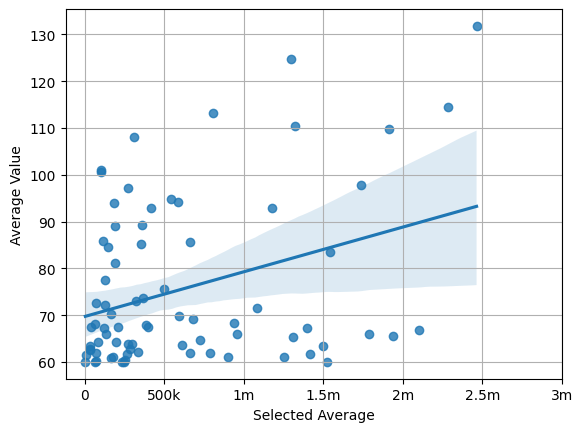

In [49]:
sb.regplot(data = star_players, x = 'selected_avg', y = 'value_avg', 
           x_jitter = 0.04);
plt.xlabel('Selected Average')
plt.ylabel('Average Value');
plt.ticklabel_format(style='plain')
plt.xticks([0, 5e5, 1e6, 1.5e6, 2e6, 2.5e6,3e6], 
           [0, '500k', '1m', '1.5m', '2m', '2.5m', '3m'])
sizes = [200, 350, 500]
base_color = sb.color_palette()[0]
legend_obj = []
plt.grid()
mpc.cursor(hover=True)
plt.show()

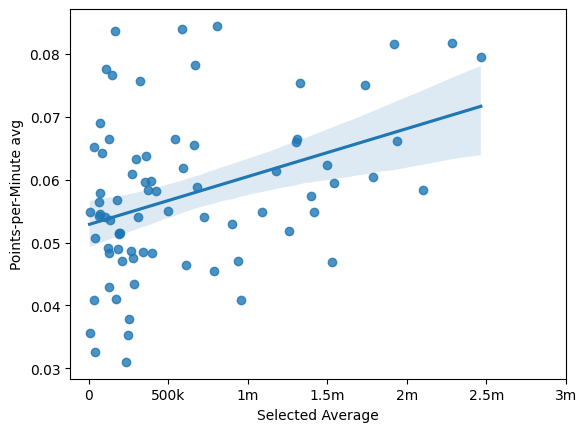

In [50]:
sb.regplot(data = star_players, x = 'selected_avg', y = 'points_per_min', 
           x_jitter = 0.04);
#scatter_kws = {'s' : fuel_econ_subset['co2']/2}
plt.xlabel('Selected Average')
plt.ylabel('Points-per-Minute avg');
plt.ticklabel_format(style='plain')
plt.xticks([0, 5e5, 1e6, 1.5e6, 2e6, 2.5e6,3e6], 
           [0, '500k', '1m', '1.5m', '2m', '2.5m', '3m'])
sizes = [200, 350, 500]
base_color = sb.color_palette()[0]
legend_obj = []

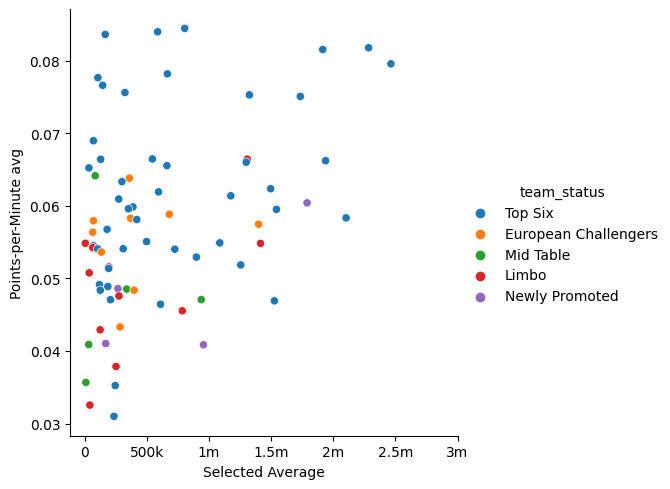

In [51]:
sb.relplot(data = star_players, x = 'selected_avg', y = 'points_per_min', hue='team_status');

plt.xlabel('Selected Average')
plt.ylabel('Points-per-Minute avg');
plt.ticklabel_format(style='plain')
plt.xticks([0, 5e5, 1e6, 1.5e6, 2e6, 2.5e6,3e6], 
           [0, '500k', '1m', '1.5m', '2m', '2.5m', '3m'])
sizes = [200, 350, 500]
base_color = sb.color_palette()[0]
legend_obj = []

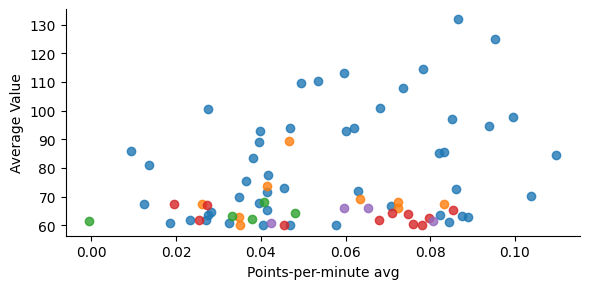

In [52]:
g = sb.FacetGrid(data = star_players, hue='team_status', aspect=2)
g.map(sb.regplot,'points_per_min', 'value_avg', 
           x_jitter = 0.04, fit_reg = False);

plt.xlabel('Points-per-minute avg')
plt.ylabel('Average Value');
plt.ticklabel_format(style='plain')
plt.show();

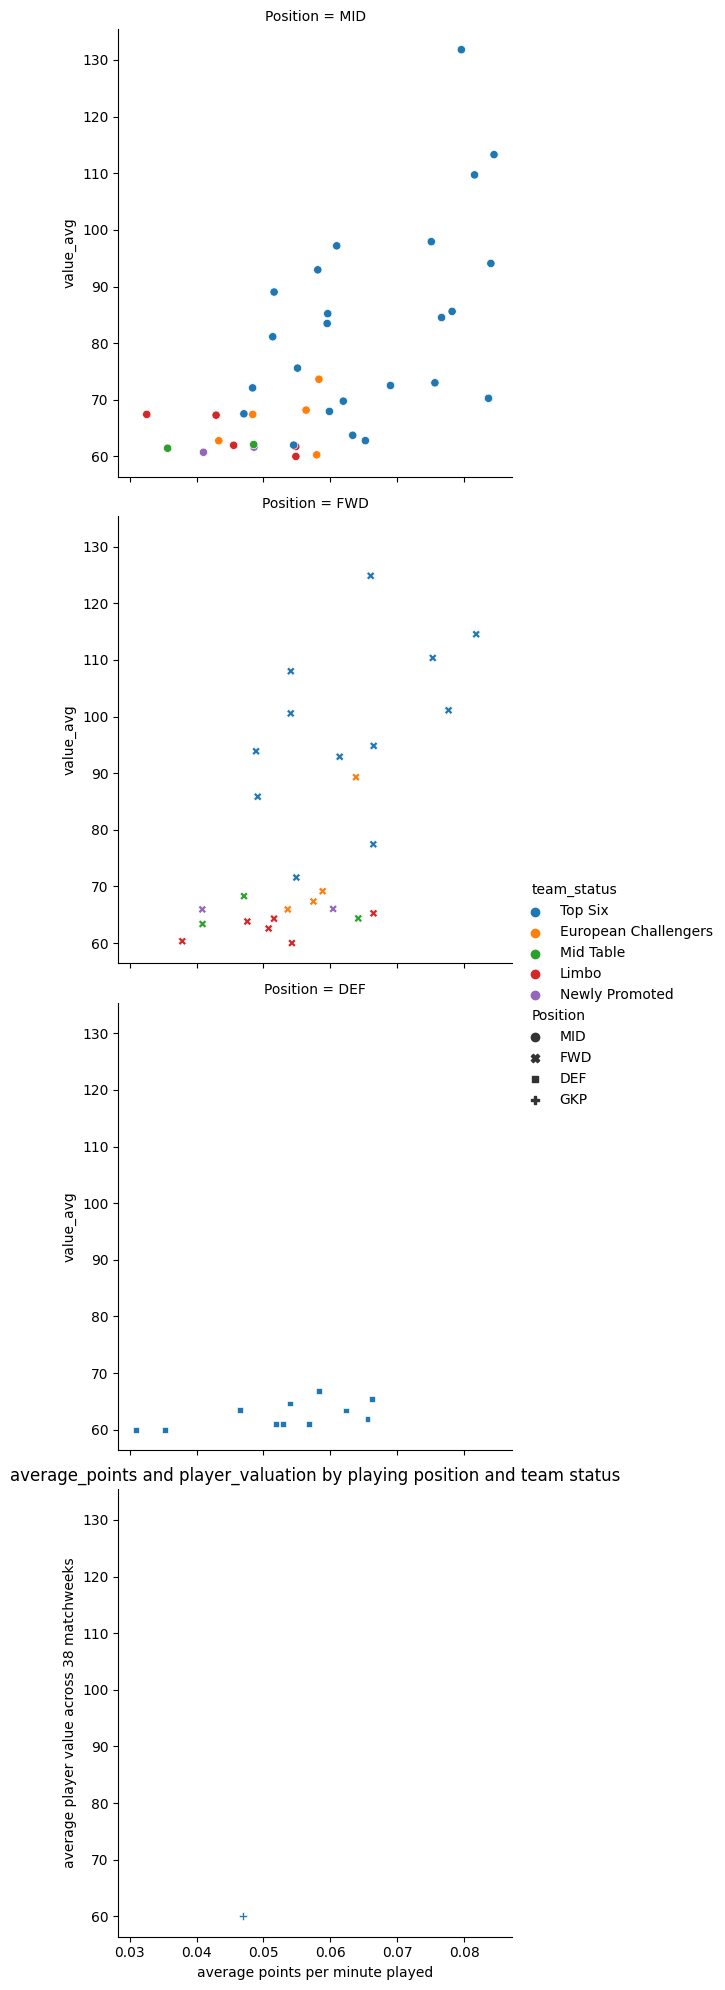

In [53]:
sb.relplot(data = star_players, x='points_per_min', y='value_avg', hue = 'team_status',  style = 'Position', row='Position');

plt.savefig('average_points_valuation by playing position and team status.png')
plt.xlabel('average points per minute played')
plt.ylabel('average player value across 38 matchweeks')
plt.title('average_points and player_valuation by playing position and team status')

plt.show();

In [54]:
fpl_pos.assists.value_counts()

0    16163
1      695
2       63
3        5
Name: assists, dtype: int64

In [55]:
fpl_pos.goals_scored.value_counts()

0    16074
1      755
2       87
3       10
Name: goals_scored, dtype: int64

In [56]:
goal_count = [
    fpl_pos['goals_scored'] == 0,
    fpl_pos['goals_scored'] == 1,
    fpl_pos['goals_scored'] == 2,
    fpl_pos['goals_scored'] == 3
]

scoring_type = ['goalless', 'single goal','brace','hattrick']

fpl_pos['scoring'] = np.select(goal_count,scoring_type)

fpl_pos.scoring.value_counts()

goalless       16074
single goal      755
brace             87
hattrick          10
Name: scoring, dtype: int64

In [57]:
for x in range(len(fpl_pos.index.tolist())):
    fpl_pos.at[x,'goal_contribution'] = fpl_pos.at[x,'goals_scored'] + fpl_pos.at[x,'assists']

In [58]:
fpl_pos.goal_contribution.value_counts()

0.0    15435
1.0     1234
2.0      214
3.0       39
4.0        4
Name: goal_contribution, dtype: int64

In [59]:
fpl_pos.goal_contribution = fpl_pos.goal_contribution.astype(int)

In [60]:
fpl_pos.goal_contribution.value_counts()

0    15435
1     1234
2      214
3       39
4        4
Name: goal_contribution, dtype: int64

In [61]:
fpl_pos.head()

first_name    last_name          full_name Position  player_id  assists  \
0      Aaron    Cresswell    Aaron Cresswell      DEF        402        0   
1      Aaron       Lennon       Aaron Lennon      MID         83        0   
2      Aaron         Mooy         Aaron Mooy      MID        199        0   
3      Aaron       Ramsey       Aaron Ramsey      MID         14        0   
4      Aaron  Wan-Bissaka  Aaron Wan-Bissaka      DEF        145        1   

   goals_conceded  goals_scored  winning_goals  big_chances_created  \
0               0             0              0                    0   
1               0             0              0                    0   
2               3             0              0                    0   
3               1             0              0                    0   
4               0             0              0                    1   

   big_chances_missed  key_passes  own_goals  clean_sheets  \
0                   0           0          0             0   
1                   1           0          0             1   
2                   0           1          0             0   
3                   0           1          0             0   
4                   0           1          0             1   

   clearances_blocks_interceptions  completed_passes  errors_leading_to_goal  \
0                                0                 0                       0   
1                                1                17                       0   
2                                2                40                       0   
3                                0                 7                       0   
4                               11                19                       0   

   fouls  penalties_conceded  penalties_missed  penalties_saved  saves  \
0      0                   0                 0                0      0   
1      1                   0                 0                0      0   
2      1                   0                 0                0      0   
3      0                   0                 0                0      0   
4      0                   0                 0                0      0   

   tackled  tackles  target_missed  recoveries  minutes  offside  \
0        0        0              0           0        0        0   
1        1        2              0           2       90        0   
2        1        6              0          11       90        0   
3        0        2              0           1       53        2   
4        2        0              0           7       90        0   

   open_play_crosses  dribbles  red_cards  yellow_cards  creativity  ea_index  \
0                  0         0          0             0         0.0         0   
1                  1         0          0             0        12.3         0   
2                  0         1          0             0        18.2         0   
3                  0         1          0             0        10.8         0   
4                  0         2          0             0        14.0         0   

   ict_index  influence  threat  bps  bonus  total_points  value  selected  \
0        0.0        0.0       0    0      0             0     55    103396   
1        3.9       10.0      17    6      0             3     50     15138   
2        3.8       20.2       0   24      0             2     55    192110   
3        2.9        9.4       9    7      0             1     75     60423   
4        6.0       46.0       0   38      3            12     40    652304   

   transfers_balance  transfers_in  transfers_out gw  loaned_in  loaned_out  \
0                  0             0              0  1          0           0   
1                  0             0              0  1          0           0   
2                  0             0              0  1          0           0   
3                  0             0              0  1          0           0   
4                  0             0              0  1 

In [62]:
goalvs = [
    (fpl_pos['goal_contribution'] == 1) & (fpl_pos['matchup'] == 0),
    (fpl_pos['goal_contribution'] == 2) & (fpl_pos['matchup'] == 0),
    (fpl_pos['goal_contribution'] == 3) & (fpl_pos['matchup'] == 0),
    (fpl_pos['goal_contribution'] == 4) & (fpl_pos['matchup'] == 0),
    
]

contribution = ['1','2','3','4']

fpl_pos['opp_equal'] = np.select(goalvs,contribution)

fpl_pos.opp_equal.value_counts()

0    16539
1      330
2       47
3       10
Name: opp_equal, dtype: int64

In [63]:
goalvs = [
    (fpl_pos['goal_contribution'] == 1) & (fpl_pos['matchup'] == 1),
    (fpl_pos['goal_contribution'] == 2) & (fpl_pos['matchup'] == 1),
    (fpl_pos['goal_contribution'] == 3) & (fpl_pos['matchup'] == 1),
    (fpl_pos['goal_contribution'] == 4) & (fpl_pos['matchup'] == 1),
    
]

contribution = ['1','2','3','4']

fpl_pos['opp_one'] = np.select(goalvs,contribution)

fpl_pos.opp_one.value_counts()

0    16594
1      255
2       65
3       10
4        2
Name: opp_one, dtype: int64

In [64]:
goalvs = [
    (fpl_pos['goal_contribution'] == 1) & (fpl_pos['matchup'] == 2),
    (fpl_pos['goal_contribution'] == 2) & (fpl_pos['matchup'] == 2),
    (fpl_pos['goal_contribution'] == 3) & (fpl_pos['matchup'] == 2),
    (fpl_pos['goal_contribution'] == 4) & (fpl_pos['matchup'] == 2),
    
]

contribution = ['1','2','3','4']

fpl_pos['opp_two'] = np.select(goalvs,contribution)

fpl_pos.opp_two.value_counts()

0    16617
1      242
2       53
3       13
4        1
Name: opp_two, dtype: int64

In [65]:
goalvs = [
    (fpl_pos['goal_contribution'] == 1) & (fpl_pos['matchup'] == 3),
    (fpl_pos['goal_contribution'] == 2) & (fpl_pos['matchup'] == 3),
    (fpl_pos['goal_contribution'] == 3) & (fpl_pos['matchup'] == 3),
    (fpl_pos['goal_contribution'] == 4) & (fpl_pos['matchup'] == 3),
    
]

contribution = ['1','2','3','4']

fpl_pos['opp_three'] = np.select(goalvs,contribution)

fpl_pos.opp_three.value_counts()

0    16830
1       76
2       17
3        3
Name: opp_three, dtype: int64

In [66]:
goalvs = [
    (fpl_pos['goal_contribution'] == 1) & (fpl_pos['matchup'] == 4),
    (fpl_pos['goal_contribution'] == 2) & (fpl_pos['matchup'] == 4),
    (fpl_pos['goal_contribution'] == 3) & (fpl_pos['matchup'] == 4),
    (fpl_pos['goal_contribution'] == 4) & (fpl_pos['matchup'] == 4),
    
]

contribution = ['1','2','3','4']

fpl_pos['opp_four'] = np.select(goalvs,contribution)

fpl_pos.opp_four.value_counts()

0    16886
1       27
2       11
4        1
3        1
Name: opp_four, dtype: int64

In [67]:
goalvs = [
    (fpl_pos['goal_contribution'] == 1) & (fpl_pos['matchup'] == -1),
    (fpl_pos['goal_contribution'] == 2) & (fpl_pos['matchup'] == -1),
    (fpl_pos['goal_contribution'] == 3) & (fpl_pos['matchup'] == -1),
    (fpl_pos['goal_contribution'] == 4) & (fpl_pos['matchup'] == -1),
    
]

contribution = ['1','2','3','4']

fpl_pos['opp_minus1'] = np.select(goalvs,contribution)

fpl_pos.opp_minus1.value_counts()

0    16704
1      202
2       19
3        1
Name: opp_minus1, dtype: int64

In [68]:
goalvs = [
    (fpl_pos['goal_contribution'] == 1) & (fpl_pos['matchup'] == -2),
    (fpl_pos['goal_contribution'] == 2) & (fpl_pos['matchup'] == -2),
    (fpl_pos['goal_contribution'] == 3) & (fpl_pos['matchup'] == -2),
    (fpl_pos['goal_contribution'] == 4) & (fpl_pos['matchup'] == -2),
    
]

contribution = ['1','2','3','4']

fpl_pos['opp_minus2'] = np.select(goalvs,contribution)

fpl_pos.opp_minus2.value_counts()

0    16834
1       89
2        2
3        1
Name: opp_minus2, dtype: int64

In [69]:
fpl_pos.head()

first_name    last_name          full_name Position  player_id  assists  \
0      Aaron    Cresswell    Aaron Cresswell      DEF        402        0   
1      Aaron       Lennon       Aaron Lennon      MID         83        0   
2      Aaron         Mooy         Aaron Mooy      MID        199        0   
3      Aaron       Ramsey       Aaron Ramsey      MID         14        0   
4      Aaron  Wan-Bissaka  Aaron Wan-Bissaka      DEF        145        1   

   goals_conceded  goals_scored  winning_goals  big_chances_created  \
0               0             0              0                    0   
1               0             0              0                    0   
2               3             0              0                    0   
3               1             0              0                    0   
4               0             0              0                    1   

   big_chances_missed  key_passes  own_goals  clean_sheets  \
0                   0           0          0             0   
1                   1           0          0             1   
2                   0           1          0             0   
3                   0           1          0             0   
4                   0           1          0             1   

   clearances_blocks_interceptions  completed_passes  errors_leading_to_goal  \
0                                0                 0                       0   
1                                1                17                       0   
2                                2                40                       0   
3                                0                 7                       0   
4                               11                19                       0   

   fouls  penalties_conceded  penalties_missed  penalties_saved  saves  \
0      0                   0                 0                0      0   
1      1                   0                 0                0      0   
2      1                   0                 0                0      0   
3      0                   0                 0                0      0   
4      0                   0                 0                0      0   

   tackled  tackles  target_missed  recoveries  minutes  offside  \
0        0        0              0           0        0        0   
1        1        2              0           2       90        0   
2        1        6              0          11       90        0   
3        0        2              0           1       53        2   
4        2        0              0           7       90        0   

   open_play_crosses  dribbles  red_cards  yellow_cards  creativity  ea_index  \
0                  0         0          0             0         0.0         0   
1                  1         0          0             0        12.3         0   
2                  0         1          0             0        18.2         0   
3                  0         1          0             0        10.8         0   
4                  0         2          0             0        14.0         0   

   ict_index  influence  threat  bps  bonus  total_points  value  selected  \
0        0.0        0.0       0    0      0             0     55    103396   
1        3.9       10.0      17    6      0             3     50     15138   
2        3.8       20.2       0   24      0             2     55    192110   
3        2.9        9.4       9    7      0             1     75     60423   
4        6.0       46.0       0   38      3            12     40    652304   

   transfers_balance  transfers_in  transfers_out gw  loaned_in  loaned_out  \
0                  0             0              0  1          0           0   
1                  0             0              0  1          0           0   
2                  0             0              0  1          0           0   
3                  0             0              0  1          0           0   
4                  0             0              0  1 

In [70]:
top_six_teams = fpl_pos.query('team_status == "Top Six"').team_title.unique().tolist()

In [71]:
top_six_clubs = fpl_pos.query('team_status == "Top Six"')
top_six_clubs 

first_name       last_name               full_name Position  player_id  \
3          Aaron          Ramsey            Aaron Ramsey      MID         14   
10          Adam         Lallana            Adam Lallana      MID        250   
15       Ainsley  Maitland-Niles  Ainsley Maitland-Niles      MID         20   
16       Alberto          Moreno          Alberto Moreno      DEF        240   
19     Alexandre       Lacazette     Alexandre Lacazette      FWD         22   
...          ...             ...                     ...      ...        ...   
16907    Vincent         Kompany         Vincent Kompany      DEF        263   
16908     Virgil        van Dijk         Virgil van Dijk      DEF        246   
16916      Willy       Caballero         Willy Caballero      GKP        112   
16920    Xherdan         Shaqiri         Xherdan Shaqiri      MID        462   
16925     Alvaro          Morata           Alvaro Morata      FWD        134   

       assists  goals_conceded  goals_scored  winning_goals  \
3            0               1             0              0   
10           0               0             0              0   
15           0               1             0              0   
16           0               0             0              0   
19           0               1             0              0   
...        ...             ...           ...            ...   
16907        0               0             0              0   
16908        0               1             0              0   
16916        0               0             0              0   
16920        0               0             2              1   
16925        0               0             0              0   

       big_chances_created  big_chances_missed  key_passes  own_goals  \
3                        0                   0           1          0   
10                       0                   0           0          0   
15                       0                   0           1          0   
16                       0                   0           0          0   
19                       0                   1           0          0   
...                    ...                 ...         ...        ...   
16907                    0                   0           0          0   
16908                    0                   0           1          0   
16916                    0                   0           0          0   
16920                    0                   0           1          0   
16925                    0                   0           0          0   

       clean_sheets  clearances_blocks_interceptions  completed_passes  \
3                 0                                0                 7   
10                0                                0                 0   
15                0                                2                11   
16                0                                0                 0   
19                0                                0                 6   
...             ...                              ...               ...   
16907             0                                0                 0   
16908             0                                0                32   
16916             0                                0                 0   
16920             0                                0                12   
16925             0                                0                 0   

       errors_leading_to_goal  fouls  penalties_conceded  penalties_missed  \
3                           0      0                   0                 0   
10                          0      0                   0                 0   
15                          0      1                   0                 0   
16                          0      0                   0                 0   
19                          0      2                   0                 0   
...                       ...    ...                 .

In [72]:
top6 = top_six_clubs.groupby(['full_name','team_title','Position']).agg(goals_total=('goals_scored',np.sum),assists_total=('assists',np.sum))

In [73]:
top6['goal_contribution'] = top6['goals_total'] + top6['assists_total']
top6 = top6.sort_values('goal_contribution', ascending=False)

In [74]:
top6 = top6.head(10)
top6

goals_total  \
full_name                 team_title        Position                
Mohamed Salah             Liverpool         MID                22   
Sergio Aguero             Manchester City   FWD                21   
Raheem Sterling           Manchester City   MID                17   
Eden Hazard               Chelsea           MID                16   
Pierre-Emerick Aubameyang Arsenal           FWD                22   
Sadio Mane                Liverpool         MID                22   
Alexandre Lacazette       Arsenal           FWD                13   
Harry Kane                Tottenham         FWD                17   
Paul Pogba                Manchester United MID                13   
Leroy Sane                Manchester City   MID                10   

                                                      assists_total  \
full_name                 team_title        Position                  
Mohamed Salah             Liverpool         MID                  12   
Sergio Aguero             Manchester City   FWD                  11   
Raheem Sterling           Manchester City   MID                  15   
Eden Hazard               Chelsea           MID                  15   
Pierre-Emerick Aubameyang Arsenal           FWD                   7   
Sadio Mane                Liverpool         MID                   3   
Alexandre Lacazette       Arsenal           FWD                  12   
Harry Kane                Tottenham         FWD                   6   
Paul Pogba                Manchester United MID                  10   
Leroy Sane                Manchester City   MID                  12   

                                                      goal_contribution  
full_name                 team_title        Position                     
Mohamed Salah             Liverpool         MID                      34  
Sergio Aguero             Manchester City   FWD                      32  
Raheem Sterling           Manchester City   MID                      32  
Eden Hazard               Chelsea           MID                      31  
Pierre-Emerick Aubameyang Arsenal           FWD                      29  
Sadio Mane                Liverpool         MID                      25  
Alexandre Lacazette       Arsenal           FWD                      25  
Harry Kane                Tottenham         FWD                      23  
Paul Pogba                Manchester United MID                      23  
Leroy Sane                Manchester City   MID                      22

In [75]:
top6_players_list = top6.index.tolist()
top6_players_list

[('Mohamed Salah', 'Liverpool', 'MID'),
 ('Sergio Aguero', 'Manchester City', 'FWD'),
 ('Raheem Sterling', 'Manchester City', 'MID'),
 ('Eden Hazard', 'Chelsea', 'MID'),
 ('Pierre-Emerick Aubameyang', 'Arsenal', 'FWD'),
 ('Sadio Mane', 'Liverpool', 'MID'),
 ('Alexandre Lacazette', 'Arsenal', 'FWD'),
 ('Harry Kane', 'Tottenham', 'FWD'),
 ('Paul Pogba', 'Manchester United', 'MID'),
 ('Leroy Sane', 'Manchester City', 'MID')]

In [76]:
prem_player = []
for player, club, pos in top6_players_list:
    prem_player.append(player)

In [77]:
prem_player

['Mohamed Salah',
 'Sergio Aguero',
 'Raheem Sterling',
 'Eden Hazard',
 'Pierre-Emerick Aubameyang',
 'Sadio Mane',
 'Alexandre Lacazette',
 'Harry Kane',
 'Paul Pogba',
 'Leroy Sane']

In [78]:
for x in range(len(prem_player)):
    player = prem_player[x]
    prem_df = fpl_pos.query('full_name == @player').sort_values('gw',ascending=True)
    prem_df['goal_cum'] = prem_df['goal_contribution'].cumsum()
    prem_df.to_csv(cwd+'\\'+folder_name+'\\'+player+' prem_df.csv')

In [79]:
top101819 = glob.glob('/Users/Dimitri/OneDrive/Desktop/Capstone/Prem FFB API/football_data/*prem_df.csv')

In [80]:
#Created a single dataframe from all files in fpl_data... As subsequent files are added to the folder, this query will merge them into one df - reset index
elite_df = pd.concat([pd.read_csv(one_file) for one_file in top101819], ignore_index=True)

In [81]:
elite_df.head()

Unnamed: 0 first_name  last_name            full_name Position  player_id  \
0          19  Alexandre  Lacazette  Alexandre Lacazette      FWD         22   
1        4935  Alexandre  Lacazette  Alexandre Lacazette      FWD         22   
2        9933  Alexandre  Lacazette  Alexandre Lacazette      FWD         22   
3       14334  Alexandre  Lacazette  Alexandre Lacazette      FWD         22   
4       14768  Alexandre  Lacazette  Alexandre Lacazette      FWD         22   

   assists  goals_conceded  goals_scored  winning_goals  big_chances_created  \
0        0               1             0              0                    0   
1        0               2             0              0                    0   
2        0               1             1              0                    0   
3        0               1             0              0                    0   
4        0               0             0              0                    0   

   big_chances_missed  key_passes  own_goals  clean_sheets  \
0                   1           0          0             0   
1                   0           1          0             0   
2                   1           2          0             0   
3                   0           1          0             0   
4                   0           0          0             0   

   clearances_blocks_interceptions  completed_passes  errors_leading_to_goal  \
0                                0                 6                       0   
1                                1                21                       0   
2                                1                17                       0   
3                                1                16                       0   
4                                0                 0                       0   

   fouls  penalties_conceded  penalties_missed  penalties_saved  saves  \
0      2                   0                 0                0      0   
1      1                   0                 0                0      0   
2      2                   0                 0                0      0   
3      0                   0                 0                0      0   
4      0                   0                 0                0      0   

   tackled  tackles  target_missed  recoveries  minutes  offside  \
0        0        0              2           2       36        0   
1        2        0              1           5       90        0   
2        3        1              1           1       90        0   
3        2        1              0           1       90        0   
4        0        0              0           0        0        0   

   open_play_crosses  dribbles  red_cards  yellow_cards  creativity  ea_index  \
0                  0         0          0             0         0.5         0   
1                  0         1          0             0        15.7         0   
2                  0         0          0             1        25.2         0   
3                  0         1          0             0        14.8         0   
4                  0         0          0             0         0.0         0   

   ict_index  influence  threat  bps  bonus  total_points  value  selected  \
0        0.2        0.0       5   -4      0             1     95    200168   
1        3.6       10.2      10    5      0             2     98    908359   
2       17.3       38.8     109   22      1             6     97    754405   
3        4.6        7.6      24    8      0             2     97    826027   
4        0.0        0.0       0    0      0             0     97    723170   

   transfers_balance  transfers_in  transfers_out  gw  loaned_in  loaned_out  \
0                  0             0              0   1          0           0   
1              80343        136788          56445   2          0           0   
2            -142820         32924         175744   3          0           0   
3              53005         90725          37720   4    

In [82]:
elite_df = elite_df.drop(columns='gw_int')

In [83]:
column_names = elite_df.columns.tolist()

In [84]:
len(column_names)

72

In [85]:
column_names

['Unnamed: 0',
 'first_name',
 'last_name',
 'full_name',
 'Position',
 'player_id',
 'assists',
 'goals_conceded',
 'goals_scored',
 'winning_goals',
 'big_chances_created',
 'big_chances_missed',
 'key_passes',
 'own_goals',
 'clean_sheets',
 'clearances_blocks_interceptions',
 'completed_passes',
 'errors_leading_to_goal',
 'fouls',
 'penalties_conceded',
 'penalties_missed',
 'penalties_saved',
 'saves',
 'tackled',
 'tackles',
 'target_missed',
 'recoveries',
 'minutes',
 'offside',
 'open_play_crosses',
 'dribbles',
 'red_cards',
 'yellow_cards',
 'creativity',
 'ea_index',
 'ict_index',
 'influence',
 'threat',
 'bps',
 'bonus',
 'total_points',
 'value',
 'selected',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'gw',
 'loaned_in',
 'loaned_out',
 'fixture',
 'opponent_team',
 'team_a_score_x',
 'team_h_score_x',
 'was_home',
 'team_title',
 'team_strength',
 'opp_team',
 'opp_strength',
 'team_status',
 'status_index',
 'matchup',
 'challenge',
 'scoring',
 'goal_c

In [88]:
new_names = ['index',
 'first_name',
 'last_name',
 'full_name',
 'Position',
 'player_id',
 'assists',
 'goals_conceded',
 'goals_scored',
 'winning_goals',
 'big_chances_created',
 'big_chances_missed',
 'key_passes',
 'own_goals',
 'clean_sheets',
 'clearances_blocks_interceptions',
 'completed_passes',
 'errors_leading_to_goal',
 'fouls',
 'penalties_conceded',
 'penalties_missed',
 'penalties_saved',
 'saves',
 'tackled',
 'tackles',
 'target_missed',
 'recoveries',
 'minutes',
 'offside',
 'open_play_crosses',
 'dribbles',
 'red_cards',
 'yellow_cards',
 'creativity',
 'ea_index',
 'ict_index',
 'influence',
 'threat',
 'bps',
 'bonus',
 'total_points',
 'value',
 'selected',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'gw',
 'loaned_in',
 'loaned_out',
 'fixture',
 'opponent_team',
 'team_a_score',
 'team_h_score',
 'was_home',
 'team_title',
 'team_strength',
 'opp_team',
 'opp_strength',
 'team_status',
 'status_index',
 'matchup',
 'challenge',
 'scoring',
 'goal_contribution',
 'opp_equal',
 'opp_one',
 'opp_two',
 'opp_three',
 'opp_four',
 'opp_minus1',
 'opp_minus2',
 'goal_cum']

In [89]:
elite_df.columns = new_names

In [90]:
elite_df

index first_name  last_name            full_name Position  player_id  \
0       19  Alexandre  Lacazette  Alexandre Lacazette      FWD         22   
1     4935  Alexandre  Lacazette  Alexandre Lacazette      FWD         22   
2     9933  Alexandre  Lacazette  Alexandre Lacazette      FWD         22   
3    14334  Alexandre  Lacazette  Alexandre Lacazette      FWD         22   
4    14768  Alexandre  Lacazette  Alexandre Lacazette      FWD         22   
..     ...        ...        ...                  ...      ...        ...   
413  12544     Sergio     Aguero        Sergio Aguero      FWD        280   
414  12969     Sergio     Aguero        Sergio Aguero      FWD        280   
415  13395     Sergio     Aguero        Sergio Aguero      FWD        280   
416  13823     Sergio     Aguero        Sergio Aguero      FWD        280   
417  14254     Sergio     Aguero        Sergio Aguero      FWD        280   

     assists  goals_conceded  goals_scored  winning_goals  \
0          0               1             0              0   
1          0               2             0              0   
2          0               1             1              0   
3          0               1             0              0   
4          0               0             0              0   
..       ...             ...           ...            ...   
413        2               0             0              0   
414        0               0             1              1   
415        0               0             1              0   
416        0               0             0              0   
417        0               0             1              1   

     big_chances_created  big_chances_missed  key_passes  own_goals  \
0                      0                   1           0          0   
1                      0                   0           1          0   
2                      0                   1           2          0   
3                      0                   0           1          0   
4                      0                   0           0          0   
..                   ...                 ...         ...        ...   
413                    1                   0           2          0   
414                    0                   0           1          0   
415                    0                   0           0          0   
416                    0                   0           0          0   
417                    0                   3           1          0   

     clean_sheets  clearances_blocks_interceptions  completed_passes  \
0               0                                0                 6   
1               0                                1                21   
2               0                                1                17   
3               0                                1                16   
4               0                                0                 0   
..            ...                              ...               ...   
413             0                                1                10   
414             1                                1                28   
415             1                                0                25   
416             1                                0                 7   
417             1                                0                19   

     errors_leading_to_goal  fouls  penalties_conceded  penalties_missed  \
0                         0      2                   0                 0   
1                         0      1                   0                 0   
2                         0      2                   0                 0   
3                         0      0                   0                 0   
4                         0      0                   0                 0   
..                      ...    ...                 ...               ...   
413                       0      0                   0                 0   
414                  

In [91]:
elite_df.full_name.unique()

array(['Alexandre Lacazette', 'Eden Hazard', 'Harry Kane', 'Leroy Sane',
       'Mohamed Salah', 'Paul Pogba', 'Pierre-Emerick Aubameyang',
       'Raheem Sterling', 'Sadio Mane', 'Sergio Aguero'], dtype=object)

In [92]:
elite_df = elite_df.set_index('index')

In [93]:
elite_df = elite_df.drop_duplicates()
elite_df

first_name  last_name            full_name Position  player_id  assists  \
index                                                                           
19     Alexandre  Lacazette  Alexandre Lacazette      FWD         22        0   
4935   Alexandre  Lacazette  Alexandre Lacazette      FWD         22        0   
9933   Alexandre  Lacazette  Alexandre Lacazette      FWD         22        0   
14334  Alexandre  Lacazette  Alexandre Lacazette      FWD         22        0   
14768  Alexandre  Lacazette  Alexandre Lacazette      FWD         22        0   
...          ...        ...                  ...      ...        ...      ...   
12544     Sergio     Aguero        Sergio Aguero      FWD        280        2   
12969     Sergio     Aguero        Sergio Aguero      FWD        280        0   
13395     Sergio     Aguero        Sergio Aguero      FWD        280        0   
13823     Sergio     Aguero        Sergio Aguero      FWD        280        0   
14254     Sergio     Aguero        Sergio Aguero      FWD        280        0   

       goals_conceded  goals_scored  winning_goals  big_chances_created  \
index                                                                     
19                  1             0              0                    0   
4935                2             0              0                    0   
9933                1             1              0                    0   
14334               1             0              0                    0   
14768               0             0              0                    0   
...               ...           ...            ...                  ...   
12544               0             0              0                    1   
12969               0             1              1                    0   
13395               0             1              0                    0   
13823               0             0              0                    0   
14254               0             1              1                    0   

       big_chances_missed  key_passes  own_goals  clean_sheets  \
index                                                            
19                      1           0          0             0   
4935                    0           1          0             0   
9933                    1           2          0             0   
14334                   0           1          0             0   
14768                   0           0          0             0   
...                   ...         ...        ...           ...   
12544                   0           2          0             0   
12969                   0           1          0             1   
13395                   0           0          0             1   
13823                   0           0          0             1   
14254                   3           1          0             1   

       clearances_blocks_interceptions  completed_passes  \
index                                                      
19                                   0                 6   
4935                                 1                21   
9933                                 1                17   
14334                                1                16   
14768                                0                 0   
...                                ...               ...   
12544                                1                10   
12969                                1                28   
13395                                0                25   
13823                                0                 7   
14254                                0                19   

       errors_leading_to_goal  fouls  penalties_conceded  penalties_missed  \
index                                                                        
19                          0      2                   0                 0   
4935                        0      1                   0                 0   
9933                    

In [94]:
prem_df

first_name last_name   full_name Position  player_id  assists  \
240        Leroy      Sane  Leroy Sane      MID        275        0   
5164       Leroy      Sane  Leroy Sane      MID        275        0   
10163      Leroy      Sane  Leroy Sane      MID        275        2   
14565      Leroy      Sane  Leroy Sane      MID        275        0   
14999      Leroy      Sane  Leroy Sane      MID        275        1   
15433      Leroy      Sane  Leroy Sane      MID        275        1   
15868      Leroy      Sane  Leroy Sane      MID        275        0   
16304      Leroy      Sane  Leroy Sane      MID        275        0   
16739      Leroy      Sane  Leroy Sane      MID        275        2   
672        Leroy      Sane  Leroy Sane      MID        275        0   
1113       Leroy      Sane  Leroy Sane      MID        275        0   
1542       Leroy      Sane  Leroy Sane      MID        275        1   
1977       Leroy      Sane  Leroy Sane      MID        275        0   
2420       Leroy      Sane  Leroy Sane      MID        275        0   
2865       Leroy      Sane  Leroy Sane      MID        275        1   
3312       Leroy      Sane  Leroy Sane      MID        275        1   
3763       Leroy      Sane  Leroy Sane      MID        275        0   
4242       Leroy      Sane  Leroy Sane      MID        275        0   
4243       Leroy      Sane  Leroy Sane      MID        275        0   
4720       Leroy      Sane  Leroy Sane      MID        275        0   
5988       Leroy      Sane  Leroy Sane      MID        275        0   
6452       Leroy      Sane  Leroy Sane      MID        275        0   
6891       Leroy      Sane  Leroy Sane      MID        275        0   
7339       Leroy      Sane  Leroy Sane      MID        275        0   
8161       Leroy      Sane  Leroy Sane      MID        275        0   
8160       Leroy      Sane  Leroy Sane      MID        275        0   
9037       Leroy      Sane  Leroy Sane      MID        275        1   
9627       Leroy      Sane  Leroy Sane      MID        275        0   
9626       Leroy      Sane  Leroy Sane      MID        275        0   
10615      Leroy      Sane  Leroy Sane      MID        275        0   
11083      Leroy      Sane  Leroy Sane      MID        275        0   
11553      Leroy      Sane  Leroy Sane      MID        275        0   
11998      Leroy      Sane  Leroy Sane      MID        275        0   
12423      Leroy      Sane  Leroy Sane      MID        275        0   
12848      Leroy      Sane  Leroy Sane      MID        275        1   
13274      Leroy      Sane  Leroy Sane      MID        275        1   
13701      Leroy      Sane  Leroy Sane      MID        275        0   
14132      Leroy      Sane  Leroy Sane      MID        275        0   

       goals_conceded  goals_scored  winning_goals  big_chances_created  \
240                 0             0              0                    0   
5164                0             0              0                    0   
10163               1             1              0                    0   
14565               0             0              0                    0   
14999               0             2              0                    1   
15433               1             0              0                    1   
15868               1             1              0                    0   
16304               1             0              0                    0   
16739               1             0              0                    2   
672                 3             0              0                    0   
1113                2             0              0                    1   
1542                0             0              0                    0   
1977                0             0              0                    0   
2420                1             1              1                    0   
2865                0             0              0                    2   
3312                0             1 

In [95]:
prem_df.isnull().sum()

first_name    0
last_name     0
full_name     0
Position      0
player_id     0
             ..
opp_three     0
opp_four      0
opp_minus1    0
opp_minus2    0
goal_cum      0
Length: 71, dtype: int64

In [96]:
prem_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 240 to 14132
Data columns (total 71 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   first_name                       38 non-null     object  
 1   last_name                        38 non-null     object  
 2   full_name                        38 non-null     object  
 3   Position                         38 non-null     object  
 4   player_id                        38 non-null     int64   
 5   assists                          38 non-null     int64   
 6   goals_conceded                   38 non-null     int64   
 7   goals_scored                     38 non-null     int64   
 8   winning_goals                    38 non-null     int64   
 9   big_chances_created              38 non-null     int64   
 10  big_chances_missed               38 non-null     int64   
 11  key_passes                       38 non-null     int64   
 12  own_g

In [114]:
prem_df.opp_equal = prem_df['opp_equal'].astype(int)
prem_df.opp_one = prem_df['opp_one'].astype(int)
prem_df.opp_two = prem_df['opp_two'].astype(int)
prem_df.opp_three = prem_df['opp_three'].astype(int)
prem_df.opp_four = prem_df['opp_four'].astype(int)
prem_df.opp_minus1 = prem_df['opp_minus1'].astype(int)
prem_df.opp_minus2 = prem_df['opp_minus2'].astype(int)

In [98]:
prem_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 240 to 14132
Data columns (total 71 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   first_name                       38 non-null     object  
 1   last_name                        38 non-null     object  
 2   full_name                        38 non-null     object  
 3   Position                         38 non-null     object  
 4   player_id                        38 non-null     int64   
 5   assists                          38 non-null     int64   
 6   goals_conceded                   38 non-null     int64   
 7   goals_scored                     38 non-null     int64   
 8   winning_goals                    38 non-null     int64   
 9   big_chances_created              38 non-null     int64   
 10  big_chances_missed               38 non-null     int64   
 11  key_passes                       38 non-null     int64   
 12  own_g

In [99]:
prem_18_teams = fpl_pos.team_title.unique().tolist()
prem_18_teams

['West Ham',
 'Burnley',
 'Huddersfield',
 'Arsenal',
 'Crystal Palace',
 'Watford',
 'Fulham',
 'Wolverhampton Wanderers',
 'Liverpool',
 'Bournemouth',
 'Everton',
 'Manchester United',
 'Southampton',
 'Brighton',
 'Chelsea',
 'Cardiff',
 'Manchester City',
 'Tottenham',
 'Leicester',
 'Newcastle']

In [101]:
#gameweeks taken to get more than 9 goal contributions
min_val_to10 = elite_df.query('goal_cum > 9')['gw'].min()

In [102]:
#first player to get more than 9 goal contributions
elite_df.query('goal_cum > 9 and gw == @min_val_to10')

first_name last_name        full_name Position  player_id  assists  \
index                                                                      
15522     Raheem  Sterling  Raheem Sterling      MID        270        0   

       goals_conceded  goals_scored  winning_goals  big_chances_created  \
index                                                                     
15522               1             1              1                    0   

       big_chances_missed  key_passes  own_goals  clean_sheets  \
index                                                            
15522                   0           2          0             0   

       clearances_blocks_interceptions  completed_passes  \
index                                                      
15522                                0                27   

       errors_leading_to_goal  fouls  penalties_conceded  penalties_missed  \
index                                                                        
15522                       0      0                   0                 0   

       penalties_saved  saves  tackled  tackles  target_missed  recoveries  \
index                                                                        
15522                0      0        3        1              0           1   

       minutes  offside  open_play_crosses  dribbles  red_cards  yellow_cards  \
index                                                                           
15522       90        0                  0         5          0             0   

       creativity  ea_index  ict_index  influence  threat  bps  bonus  \
index                                                                   
15522        25.4         0       13.8       43.8      69   37      2   

       total_points  value  selected  transfers_balance  transfers_in  \
index                                                                   
15522             9    114    991157             357101        362525   

       transfers_out  gw  loaned_in  loaned_out  fixture  opponent_team  \
index                                                                     
15522           5424   6          0           0      138              2   

       team_a_score  team_h_score  was_home       team_title  team_strength  \
index                                                                         
15522             1             3      True  Manchester City              5   

          opp_team  opp_strength team_status  status_index  matchup  \
index                                                                 
15522  Bournemouth             3     Top Six           1.0        2   

        challenge      scoring  goal_contribution  opp_equal  opp_one  \
index                                                                   
15522  advantaged  single goal                  1        0.0      0.0   

       opp_two  opp_three  opp_four  opp_minus1  opp_minus2  goal_cum  
index                                                                  
15522      1.0        0.0       0.0         0.0         0.0        10

In [104]:
matchup_val = elite_df.matchup.unique().tolist()

In [103]:
#players who scored or assisted in the first gameweek
elite_df.query('goal_cum > 0 and gw == 1')

first_name last_name        full_name Position  player_id  assists  \
index                                                                      
126         Eden    Hazard      Eden Hazard      MID        122        1   
288      Mohamed     Salah    Mohamed Salah      MID        253        0   
313         Paul     Pogba       Paul Pogba      MID        302        0   
325       Raheem  Sterling  Raheem Sterling      MID        270        0   
350        Sadio      Mane       Sadio Mane      MID        251        0   

       goals_conceded  goals_scored  winning_goals  big_chances_created  \
index                                                                     
126                 0             0              0                    1   
288                 0             1              1                    0   
313                 0             1              0                    0   
325                 0             1              1                    0   
350                 0             2              0                    0   

       big_chances_missed  key_passes  own_goals  clean_sheets  \
index                                                            
126                     0           1          0             0   
288                     1           2          0             1   
313                     0           0          0             1   
325                     0           1          0             1   
350                     0           2          0             1   

       clearances_blocks_interceptions  completed_passes  \
index                                                      
126                                  0                20   
288                                  1                22   
313                                  3                54   
325                                  1                24   
350                                  0                27   

       errors_leading_to_goal  fouls  penalties_conceded  penalties_missed  \
index                                                                        
126                         0      1                   0                 0   
288                         0      0                   0                 0   
313                         0      1                   0                 0   
325                         0      3                   0                 0   
350                         0      0                   0                 0   

       penalties_saved  saves  tackled  tackles  target_missed  recoveries  \
index                                                                        
126                  0      0        0        0              0           1   
288                  0      0        6        0              1           3   
313                  0      0        5        0              0           7   
325                  0      0        7        0              0           2   
350                  0      0        3        3              1           5   

       minutes  offside  open_play_crosses  dribbles  red_cards  yellow_cards  \
index                                                                           
126         14        0                  0         6          0             0   
288         86        1                  0         1          0             0   
313         83        0                  0         6          0             0   
325         86        0                  0         3          0             1   
350         81        1                  1         1          0             0   

       creativity  ea_index  ict_index  influence  threat  bps  bonus  \
index                                                                   
126          13.8         0        4.8       23.8      10   21      0   
288          29.0         0       16.9       47.6      92   20      0   
313           9.9         0        9.1       56.8      24   29      2   
325          17.8         0       10

In [119]:
scoring_list = prem_df['scoring'].unique().tolist()

In [125]:
fpl_pos.at[4243,'selected'] = 1349099

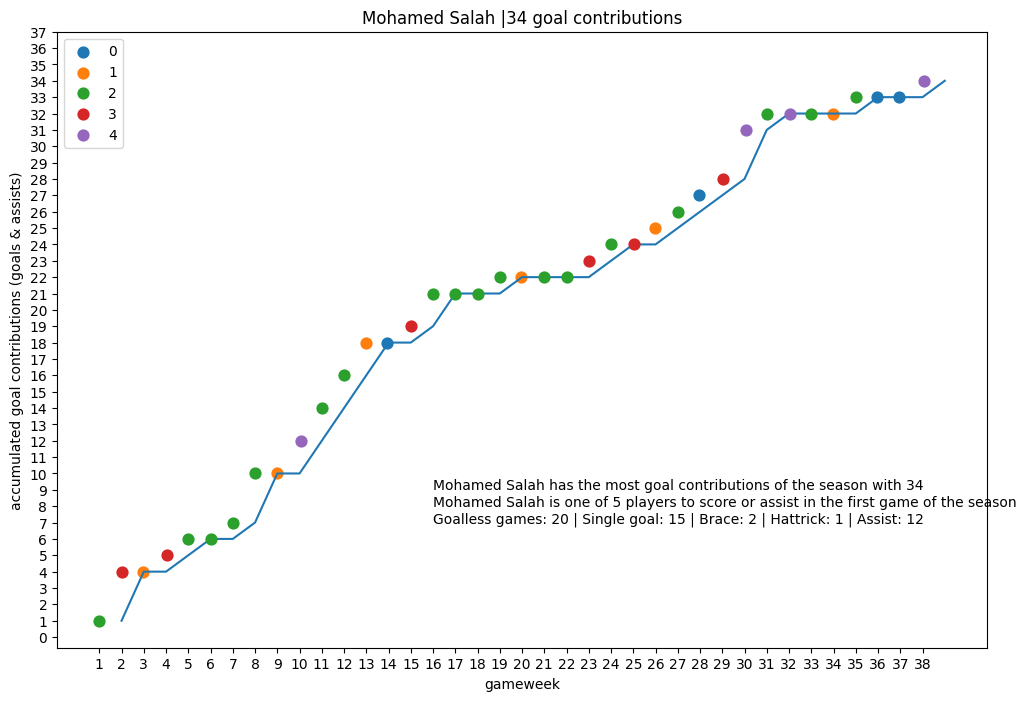

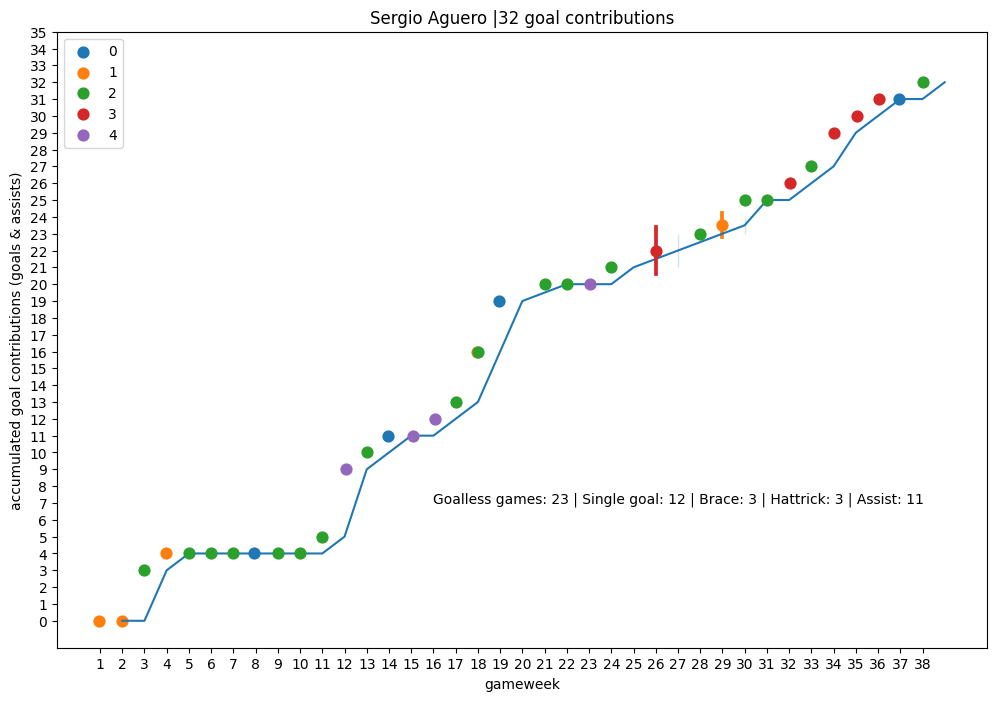

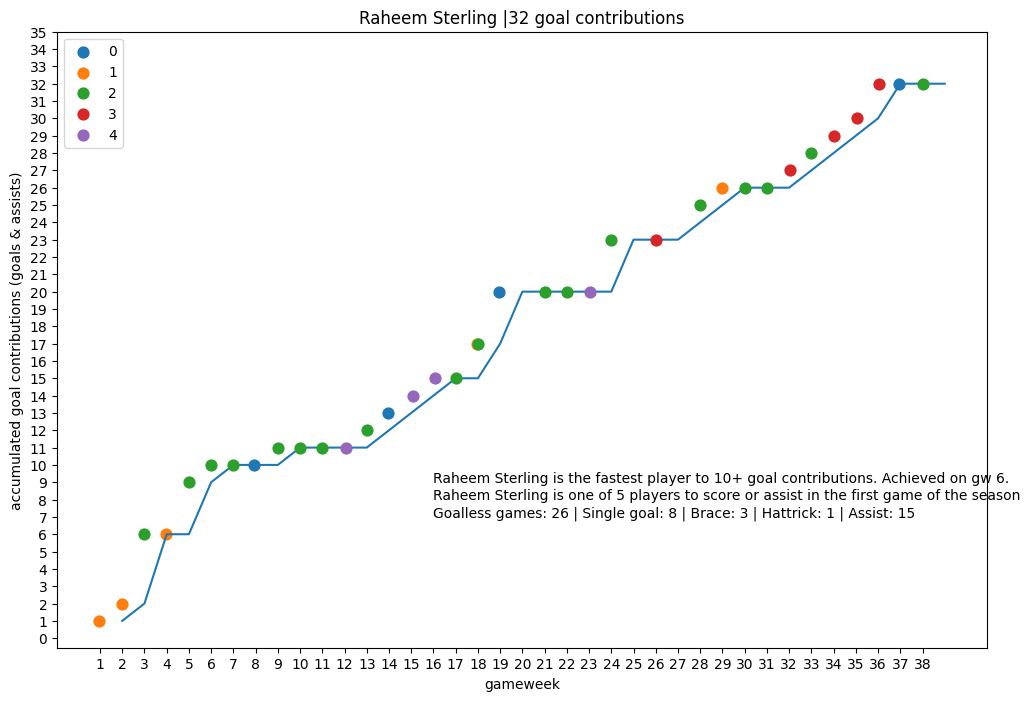

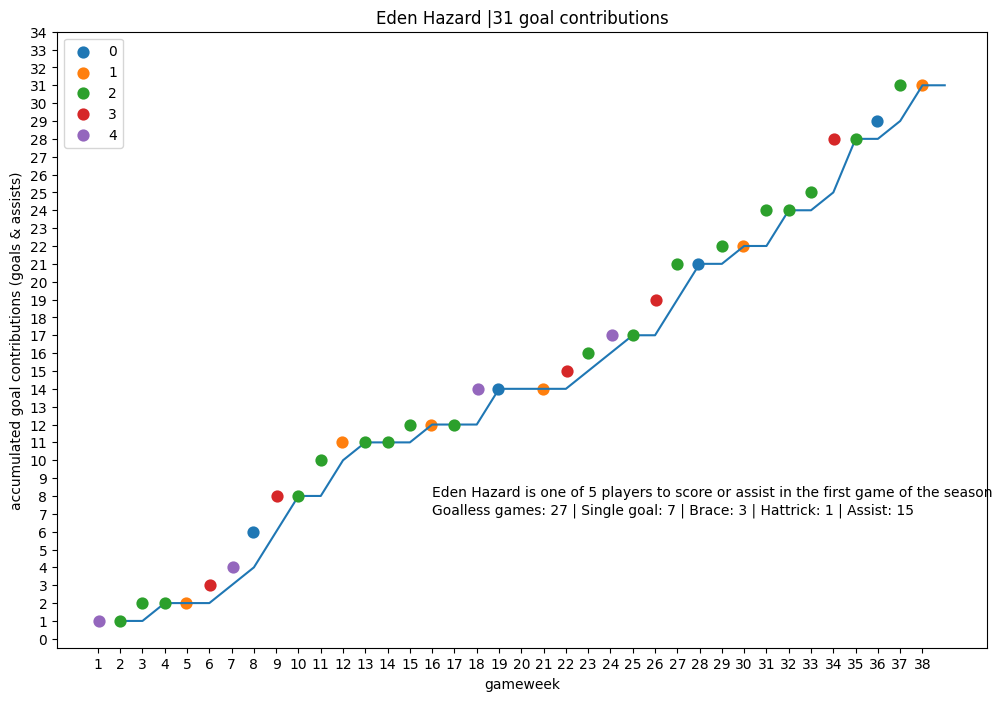

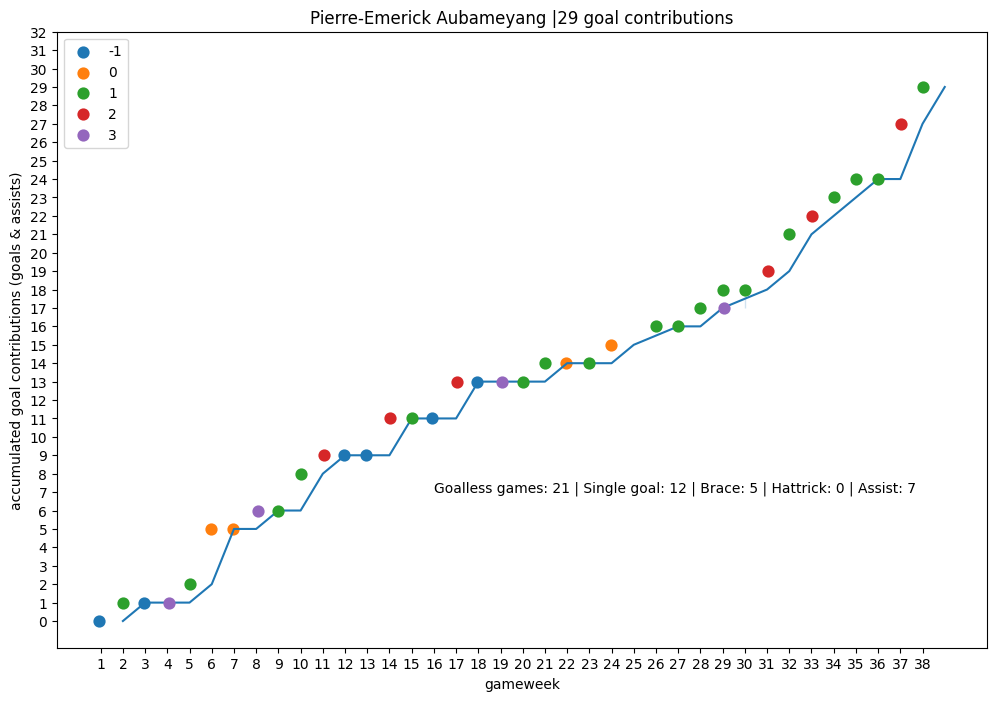

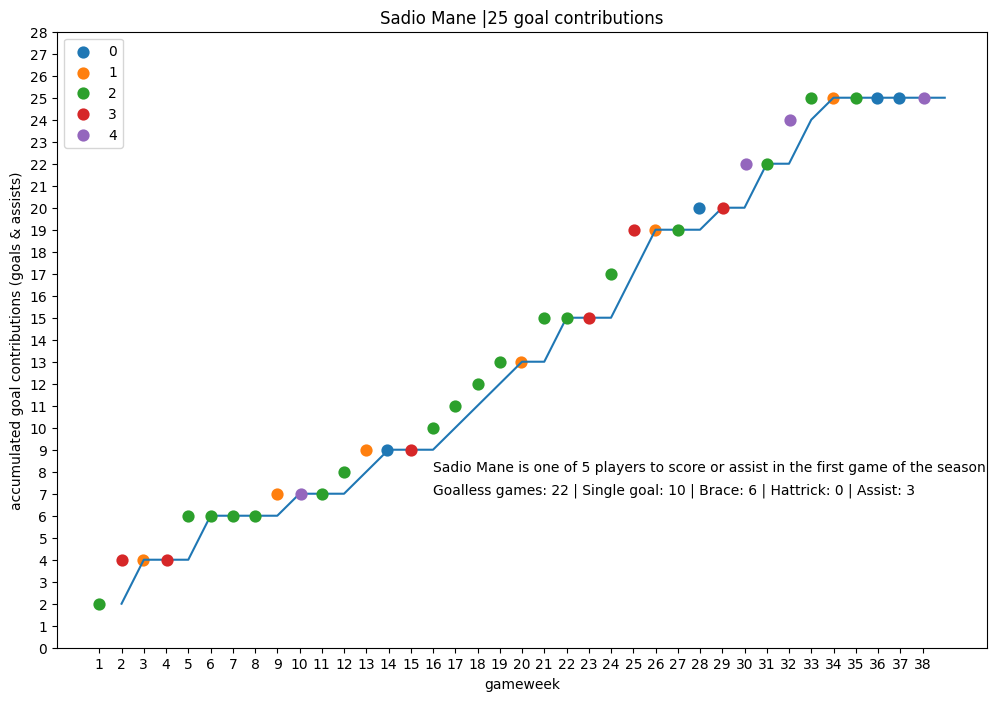

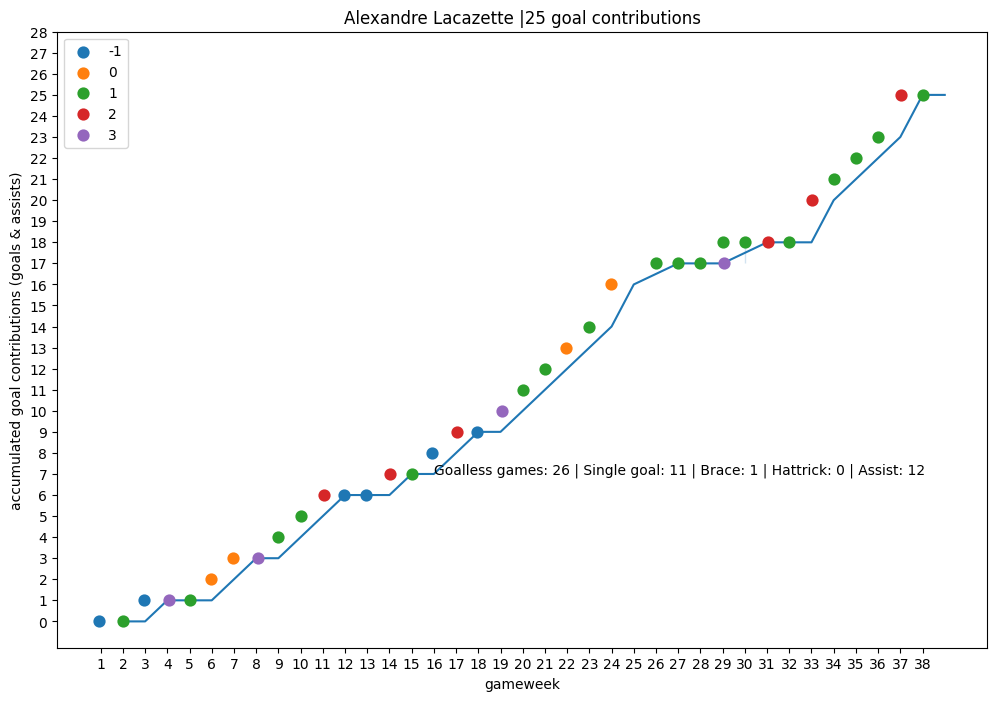

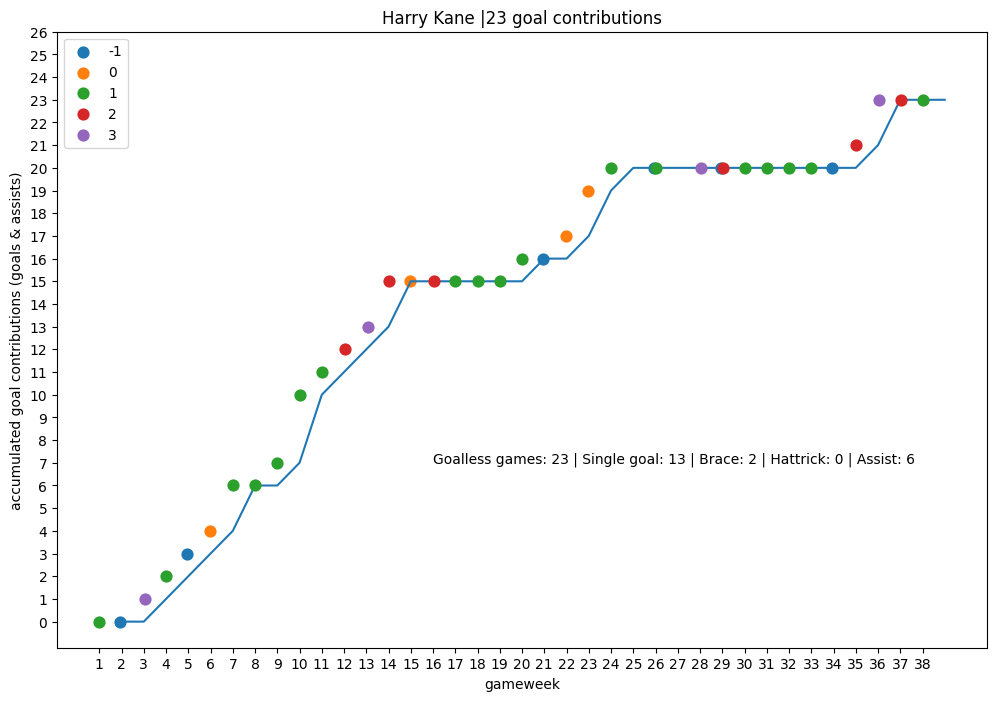

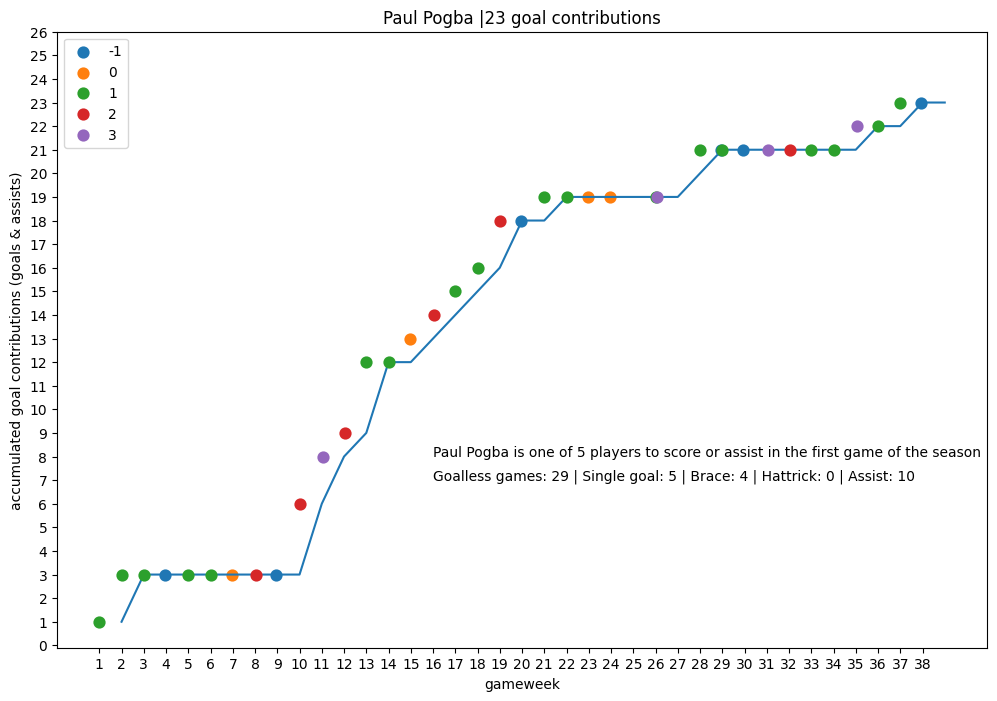

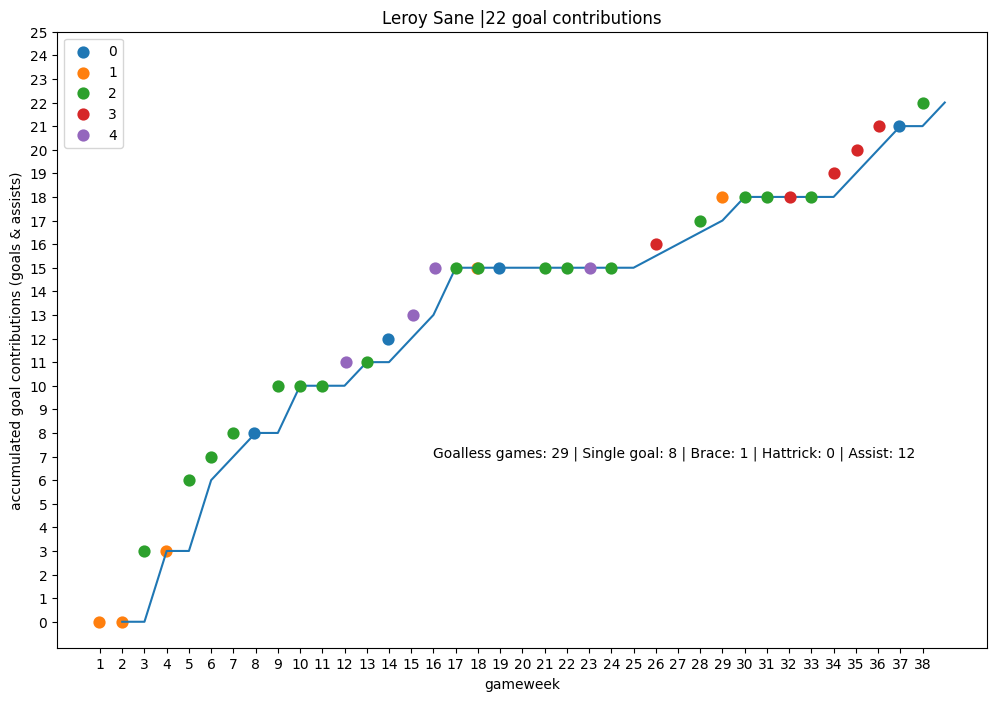

In [ ]:


for x in range(len(prem_player)):
    #VARIABLES
    player = prem_player[x]
    prem_df = fpl_pos.query('full_name == @player').sort_values('gw')
    prem_df['goal_cum'] = prem_df['goal_contribution'].cumsum()
    goal_contributions = prem_df.goal_contribution.sum()
    contribution_total = prem_df.goal_cum.max()
    goalless = prem_df['scoring'].value_counts()[0]
    single = prem_df['scoring'].value_counts()[1]
    brace = prem_df['scoring'].value_counts()[2]
    most_goals = elite_df.goal_cum.max()
    
    least_gw = elite_df.query('goal_cum > 9')['gw'].min()
    first_week_count = len(elite_df.query('goal_cum > 0 and gw == 1')['full_name'].unique().tolist())
    
    scoring_list = prem_df['scoring'].unique().tolist()
    if len(scoring_list) == 4:
        hattrick = prem_df['scoring'].value_counts()[3]
    elif len(scoring_list) == 3 and 'hattrick' in scoring_list:
        hattrick = prem_df['scoring'].value_counts()[2]
    else:
        hattrick = 0
            
    assists = prem_df['assists'].sum()
    
    
    #fastest player to 10 goal contributions
    if player in elite_df.query('goal_cum > 9 and gw == @min_val_to10')['full_name'].unique().tolist():
        fastest_to_10 = player
    else:
        fastest_to_10 = ' '
    
    #player/players with goal contributions first game of the season
    if player in elite_df.query('goal_cum > 0 and gw == 1')['full_name'].unique().tolist():
        first_gw = player
    
    #player with most goal contributions of the season
    if player in elite_df.query('goal_cum == @most_goals')['full_name'].unique().tolist():
        top_scorer = player
    else:
        top_scorer = ' '
    
    
    plt.figure(figsize=[12, 8])
    
    
    ylist = np.arange(0,goal_contributions+4,1)
    #new_list = [i for i in ylist]
    ylabel = ['{:0.0f}'.format(i) for i in ylist]

    base_color = sb.color_palette()[0]

    sb.pointplot(data = prem_df, x='gw', y='goal_cum', errorbar='sd', hue='opposition_status', linestyles = "", dodge = True);
    sb.lineplot(data = prem_df, x='gw', y='goal_cum', color=base_color);
    plt.xlabel('gameweek')
    plt.ylabel("accumulated goal contributions (goals & assists)")
    plt.yticks(ylist, ylabel)
    plt.title(player + ' |' +str(contribution_total) + ' goal contributions')
    plt.savefig(player+' goal contributions 2018.png')
    
    
    
    text = 'Goalless games: '+ str(goalless) +' | Single goal: ' +str(single) +' | Brace: '+str(brace) + ' | Hattrick: '+str(hattrick) + ' | Assist: '+str(assists)
    
    if fastest_to_10 == player:
        text1 = player+' is the fastest player to 10+ goal contributions. Achieved on gw ' + str(least_gw)+'.'
    else:
        text1 = ' '
    
    if first_gw == player:
        text2 = player+' is one of '+ str(first_week_count) + ' players to score or assist in the first game of the season'
    else:
        text2 = ' '
        
    if top_scorer == player:
        text3 = player+ ' has the most goal contributions of the season with '+str(contribution_total)
    else:
        text3 = ' '
    
    plt.text(15,7, text)
    plt.text(15,9, text1)
    plt.text(15,8, text2)
    plt.text(15,9, text3)
    
    plt.show();

In [109]:
top_ballers_10 = fpl_pos[fpl_pos['full_name'].isin(prem_player)]

In [111]:
max_player_selection = fpl_pos.selected.max()

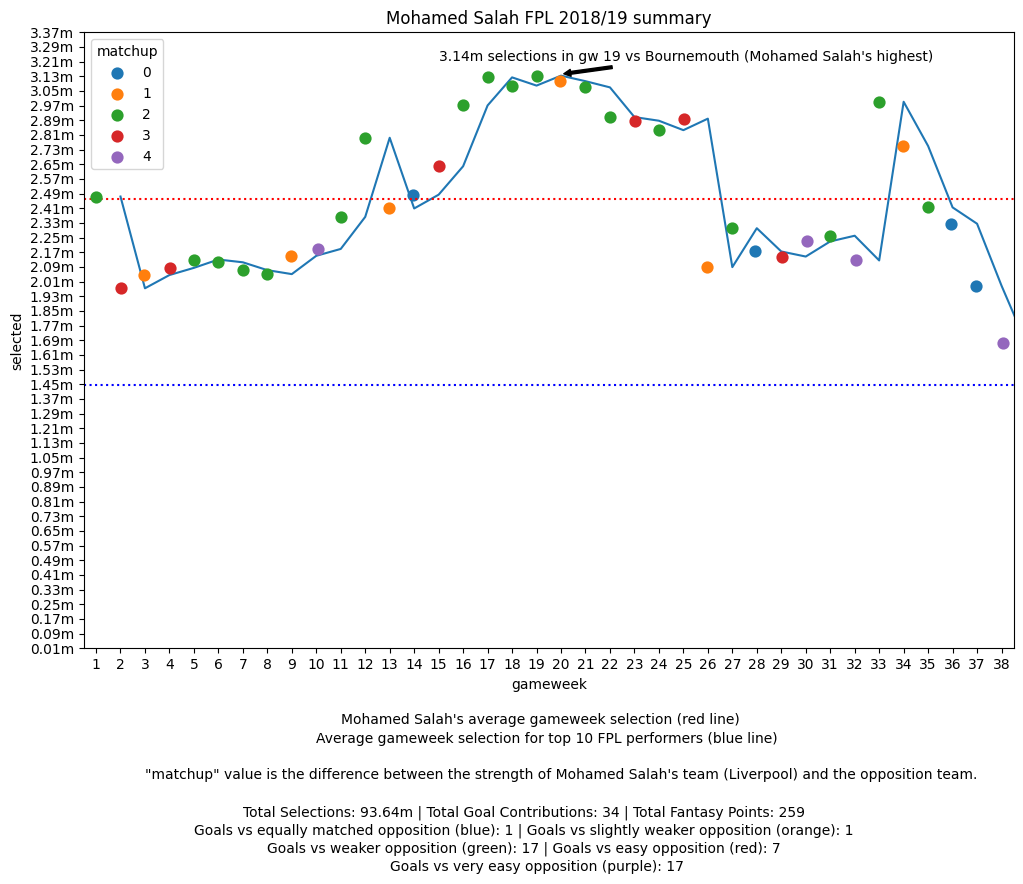

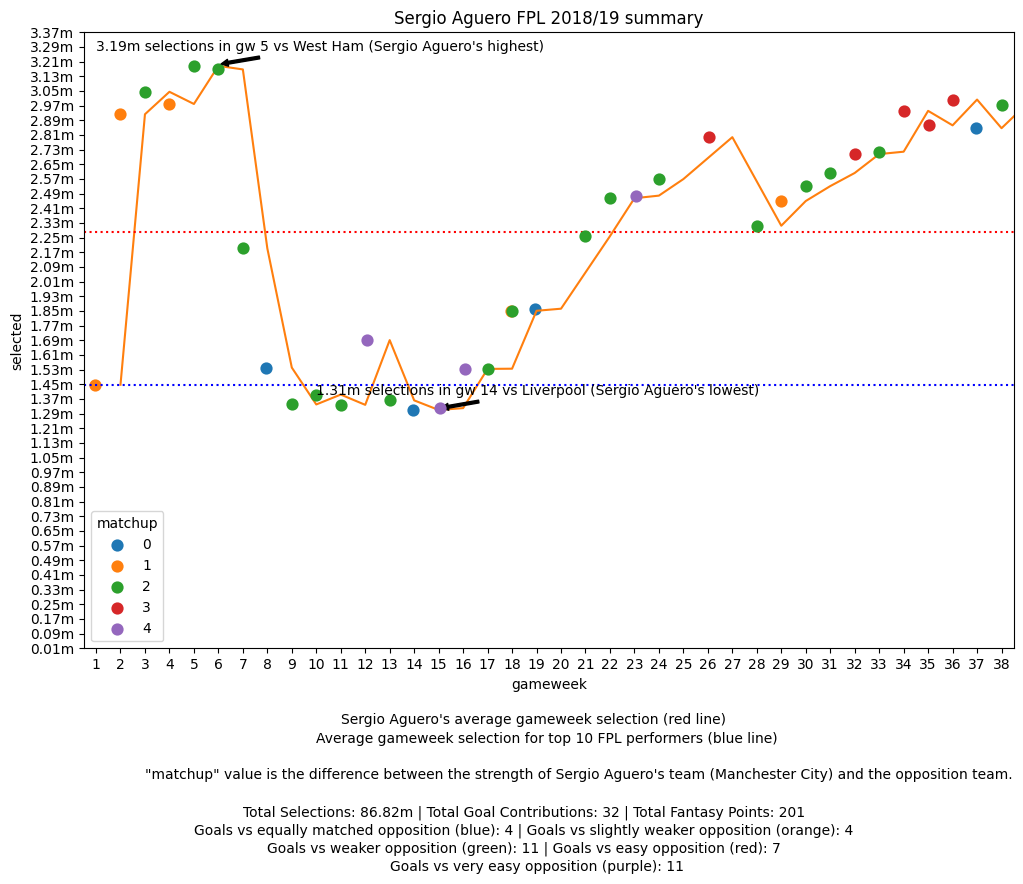

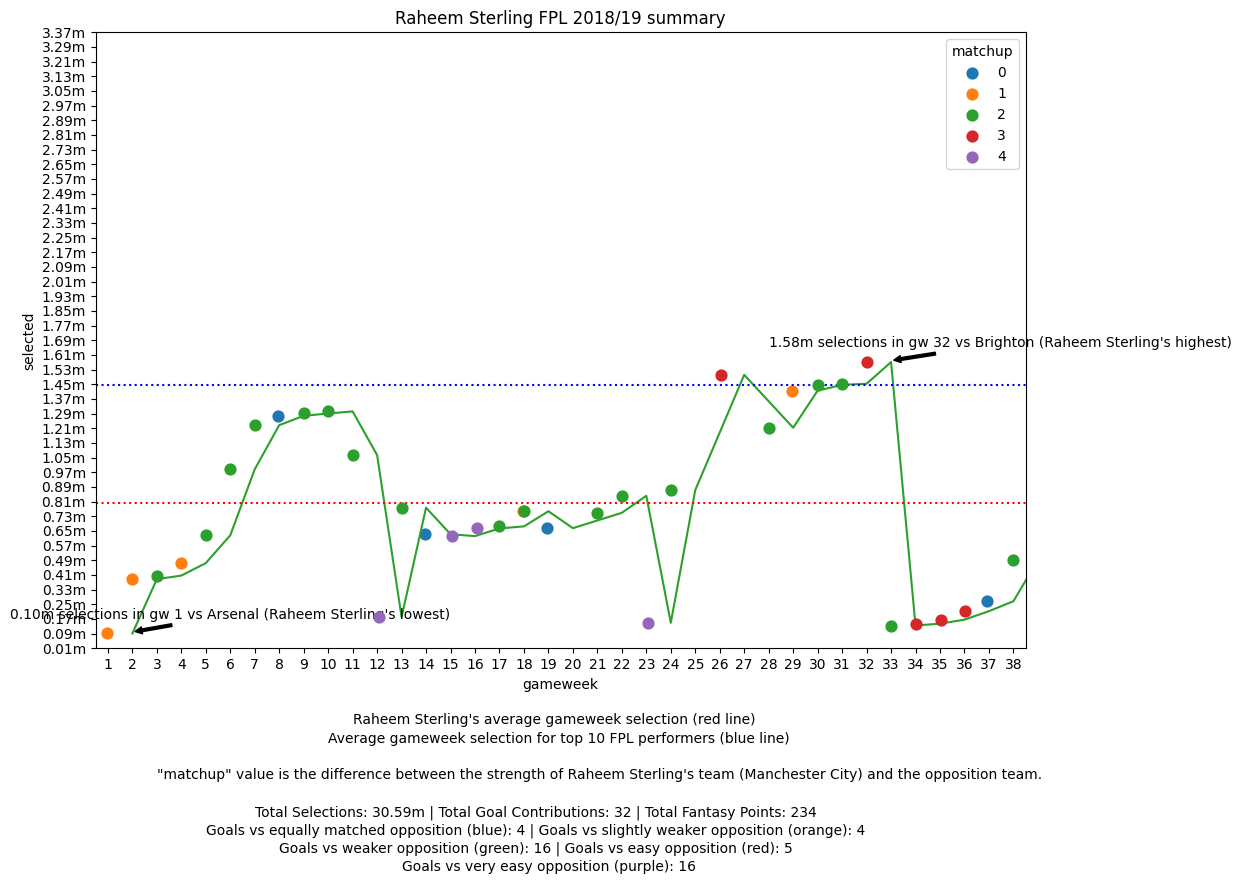

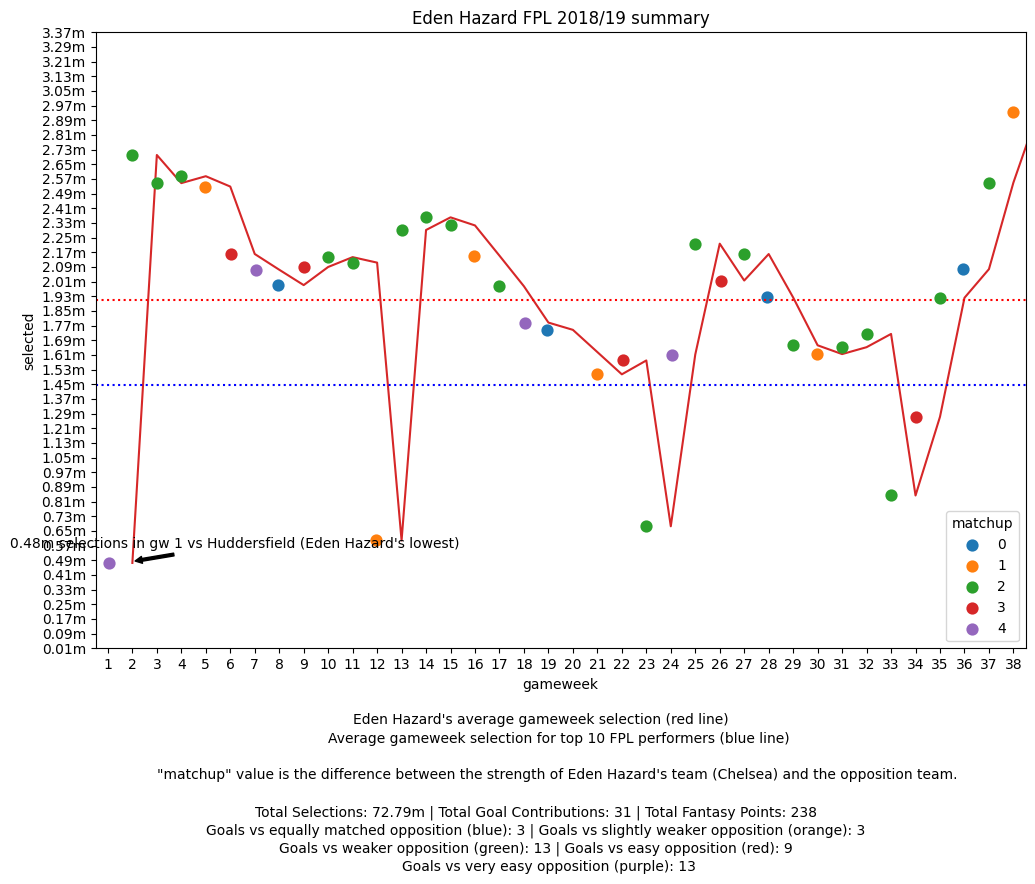

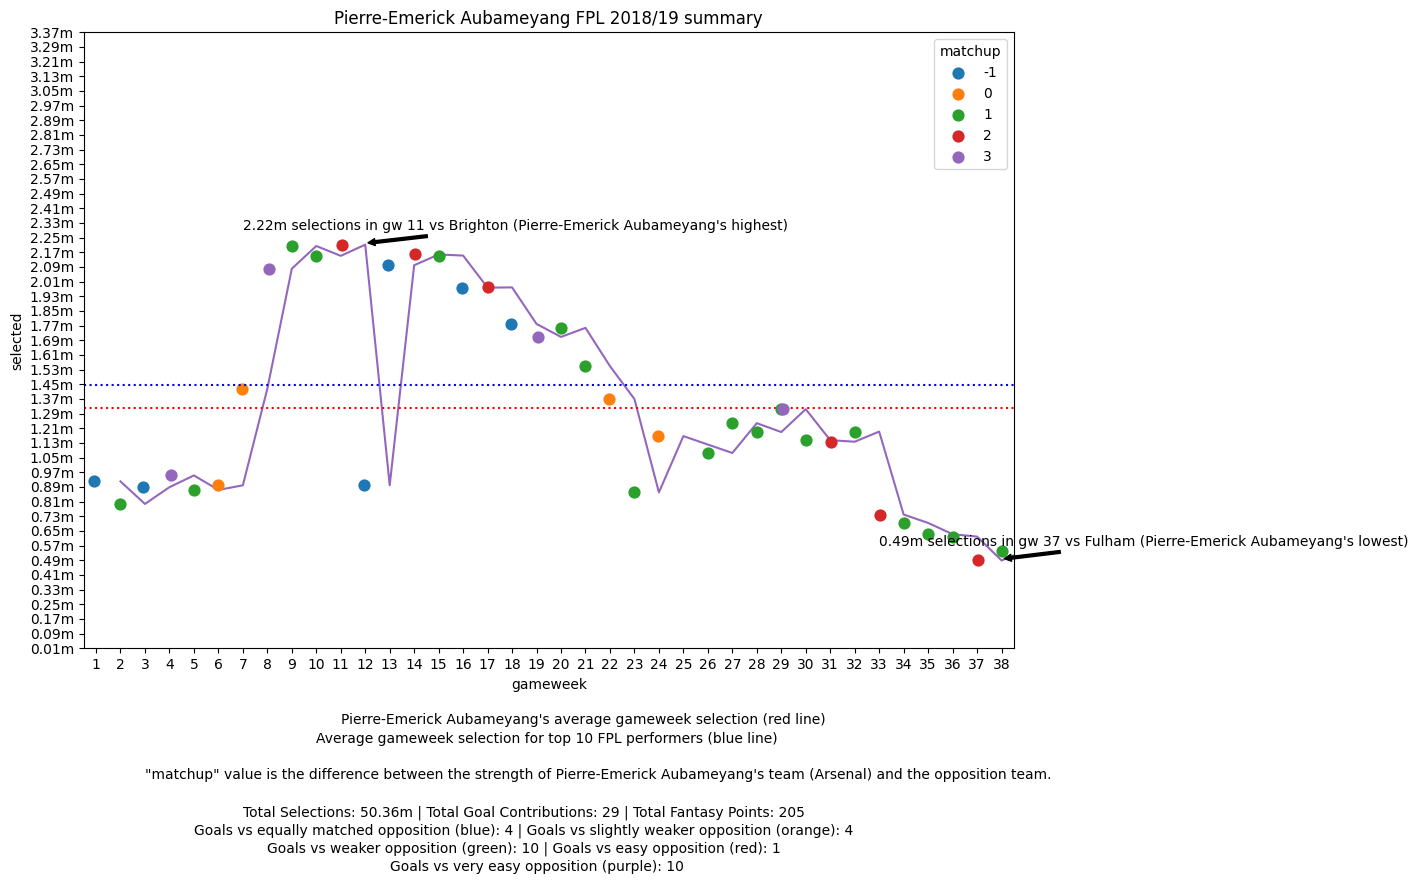

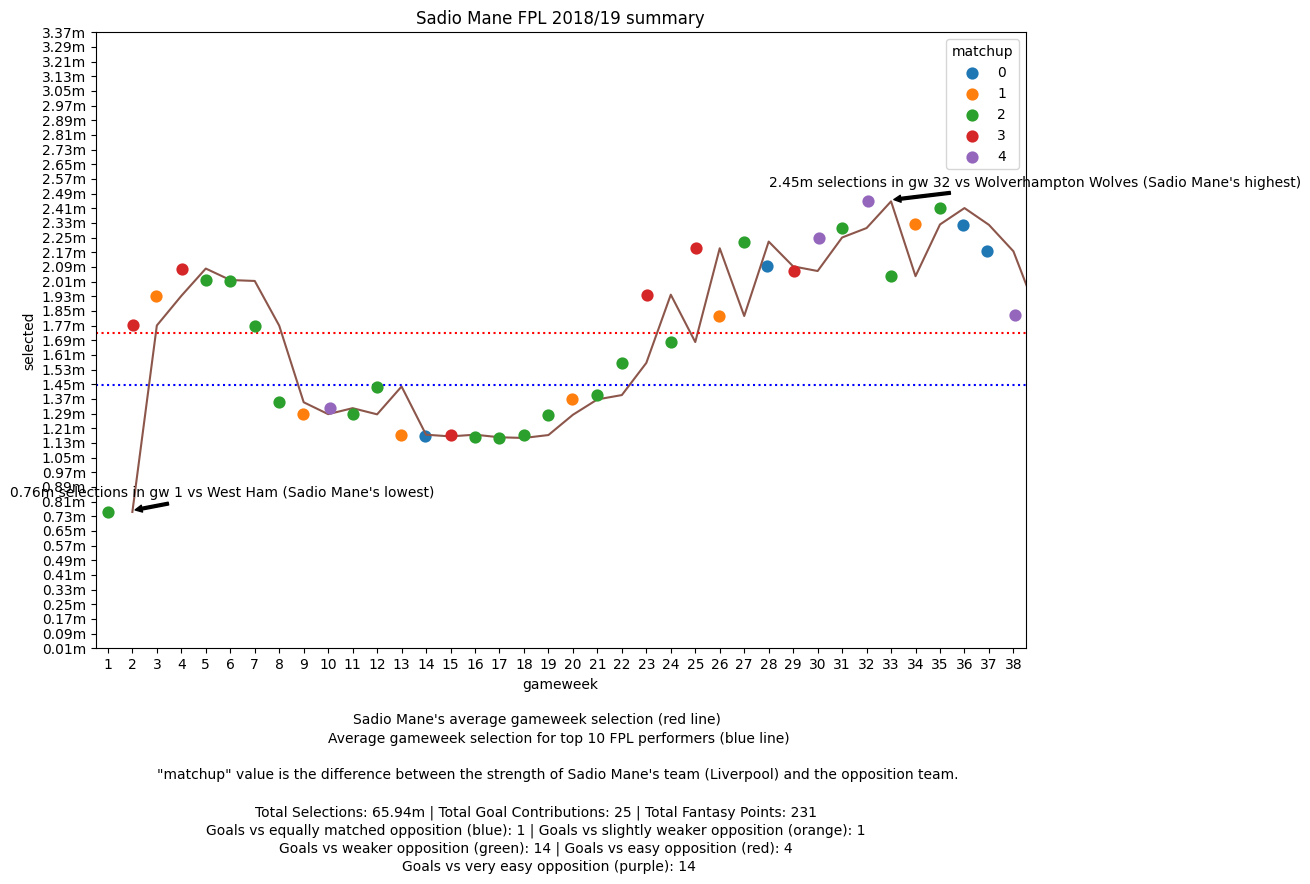

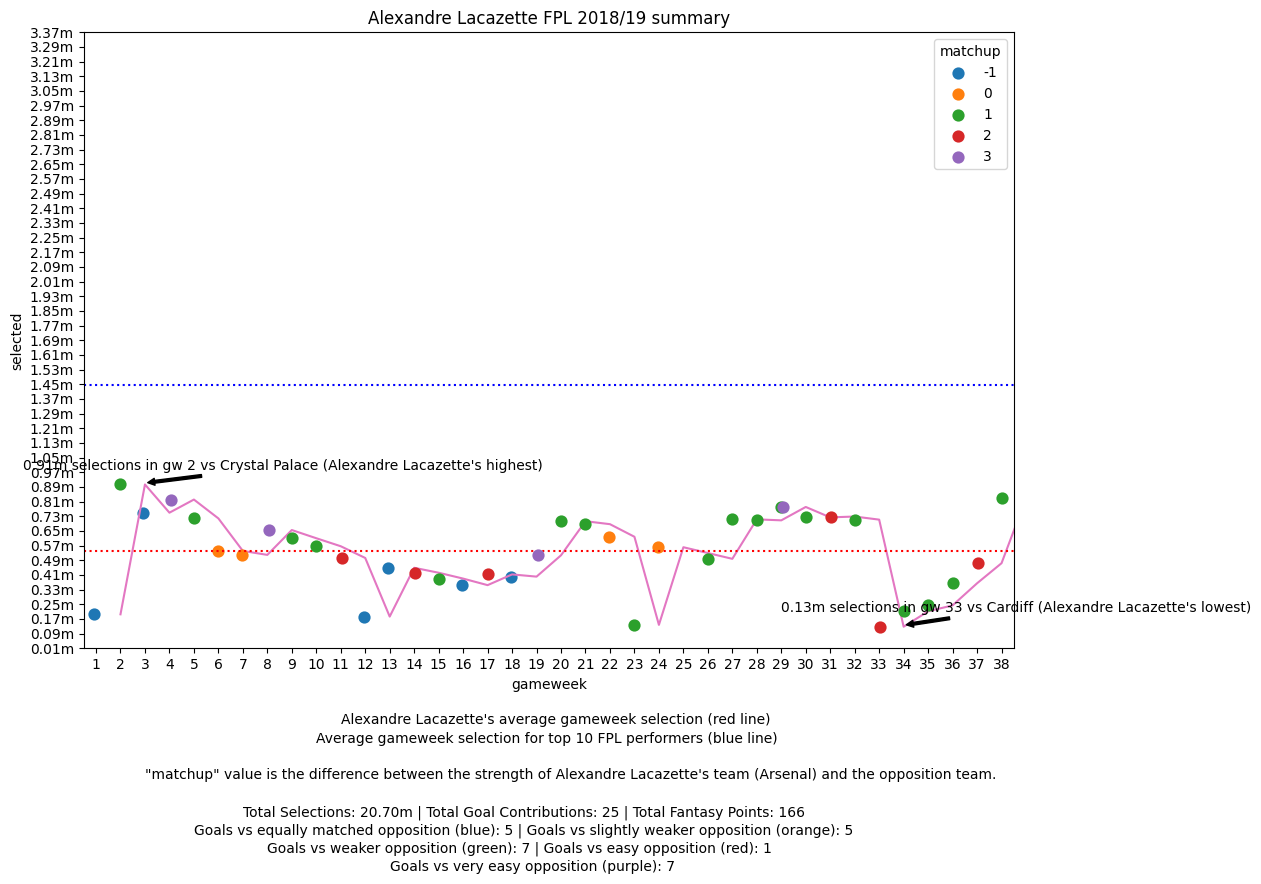

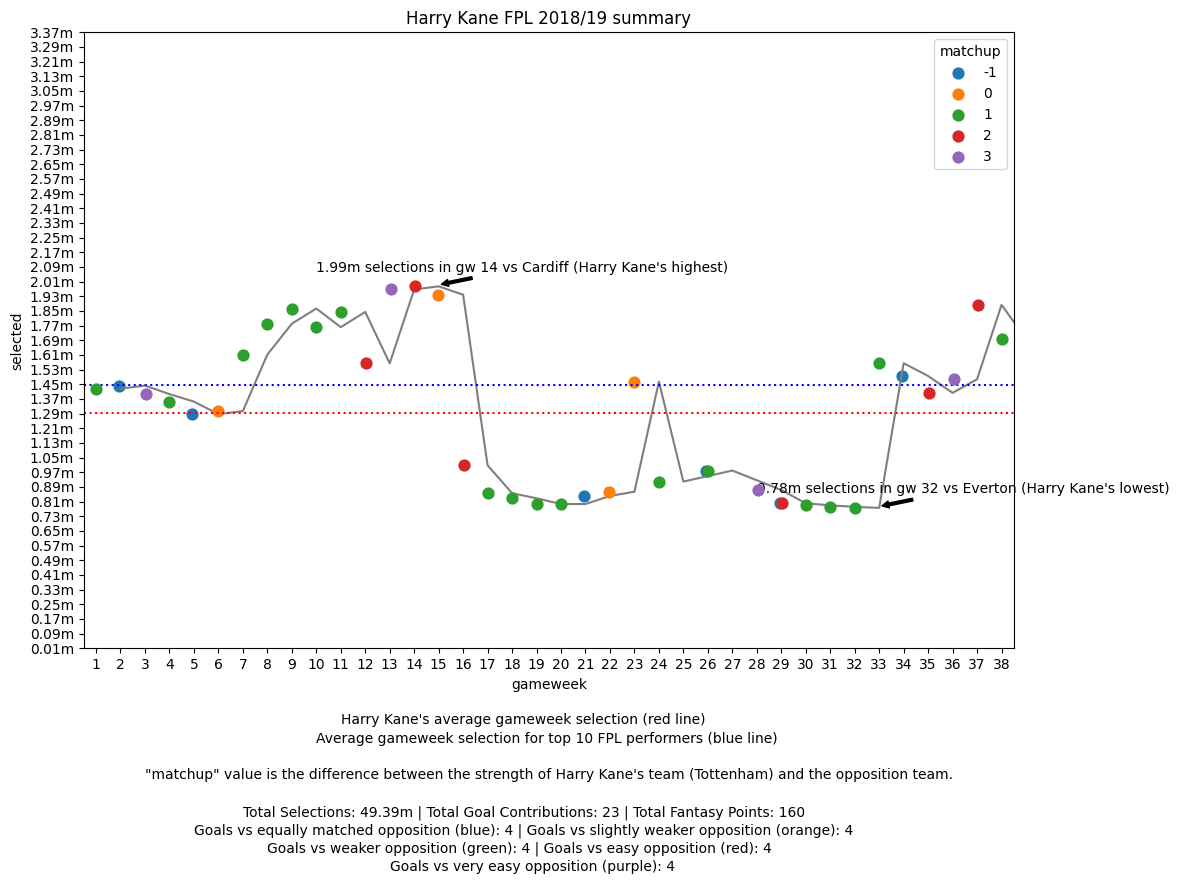

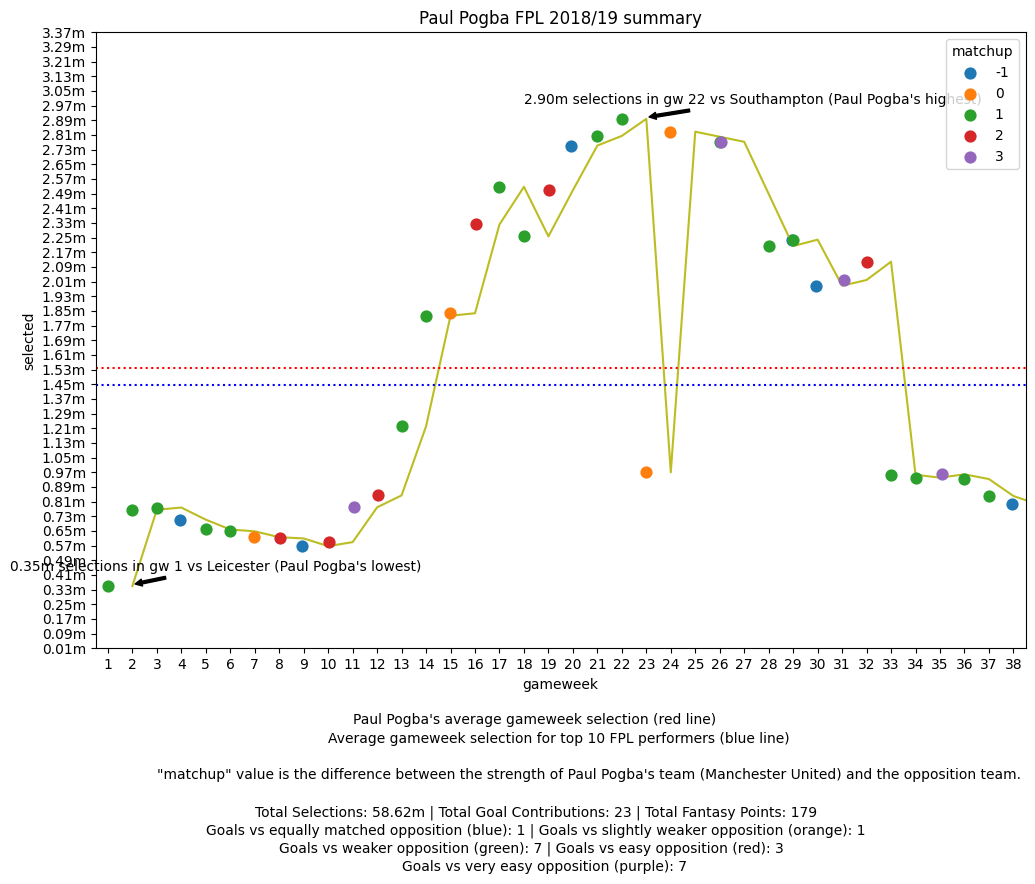

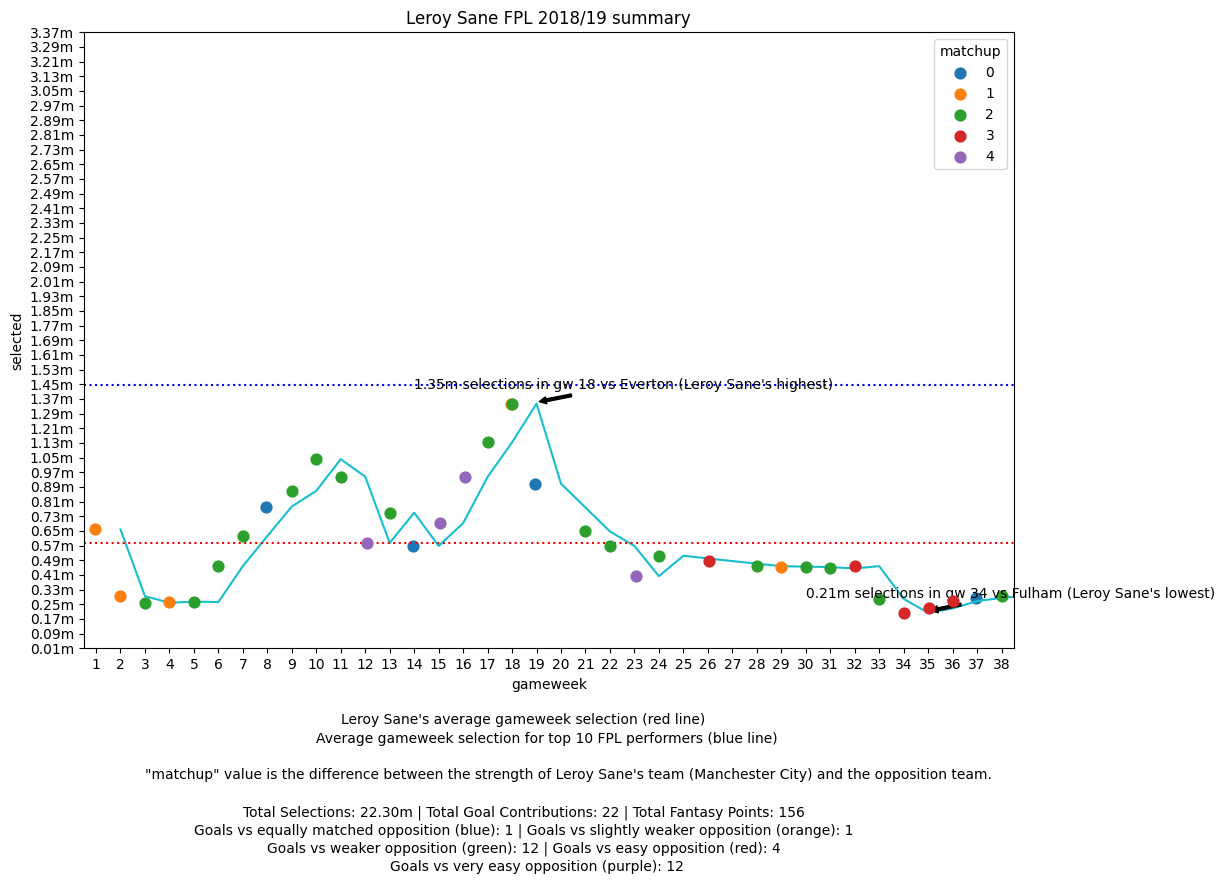

In [ ]:
for x in range(len(prem_player)):
    player = prem_player[x]
    prem_df = fpl_pos.query('full_name == @player').sort_values('gw')
    plt.figure(figsize=[12, 8])

    ax = fig.add_axes([.1,.1,1,1])
    
    player_team = prem_df.query('full_name==@player')['team_title'].max()
    player_mean = prem_df.selected.mean()
    elite_mean = top_ballers_10.selected.mean()
    
    sum_selection = '{:0.2f}m'.format(prem_df.selected.sum()/1e6)
    sum_points = prem_df.total_points.sum()
    sum_cum = prem_df.goal_contribution.sum()

    sum_equal = prem_df.opp_equal.astype(int).sum()
    sum_two = prem_df.opp_two.astype(int).sum()
    sum_three = prem_df.opp_three.astype(int).sum()
    sum_four = prem_df.opp_four.astype(int).sum()
    sum_minus1 = prem_df.opp_minus1.astype(int).sum()
    sum_minus2 = prem_df.opp_minus2.astype(int).sum()
    
    anno_max_selected = prem_df.query('full_name==@player')['selected'].max()
    anno_max_team = prem_df.query('selected== @anno_max_selected')['opp_team'].max()
    anno_max_gw = prem_df.query('selected== @anno_max_selected')['gw'].max()
    max_selected_formatted = '{:0.2f}m'.format(anno_max_selected/1e6)
    anno_max = str(max_selected_formatted) +' selections in gw '+str(anno_max_gw)+ ' vs ' +anno_max_team + ' ('+player+"'s highest)"
    
    anno_min_selected = prem_df.query('full_name==@player')['selected'].min()
    anno_min_team = prem_df.query('selected== @anno_min_selected')['opp_team'].min()
    min_selected_formatted = '{:0.2f}m'.format(anno_min_selected/1e6)
    anno_min_gw = prem_df.query('selected== @anno_min_selected')['gw'].min()
    anno_min = str(min_selected_formatted) +' selections in gw '+str(anno_min_gw)+ ' vs ' +anno_min_team + ' ('+player+"'s lowest)"
    
    anno_mean = prem_df.query('full_name==@player')['selected'].mean()
    prem_max = max_player_selection
    prem_min = top_ballers_10.selected.min()
    ylist = np.arange(prem_min-80495,prem_max+200000,80000)
    new_list = [(i/1e6) for i in ylist]
    ylabel = ['{:0.2f}m'.format(i) for i in new_list]

    base_color = sb.color_palette()[x]
    sb.lineplot(data = prem_df, x='gw', y='selected', color=base_color);
    sb.pointplot(data = prem_df.sort_values(['gw']), x='gw', y='selected',errorbar='sd', hue = 'opposition_status', linestyles = "", dodge = True);
    
    plt.axhline( y=player_mean, color = 'r', linestyle=':')
    plt.axhline( y=elite_mean, color = 'b', linestyle=':')
    
    plt.xlabel('gameweek')
    plt.ylabel('selected')
    plt.yticks(ylist, ylabel)
    plt.title(player + ' FPL 2018/19 summary')
    plt.savefig(player + ' gameweek selections')
    
    
    plt.annotate(anno_max, xy=(prem_df.query('selected== @anno_max_selected')['gw'].astype(int),anno_max_selected+8000), xytext=(prem_df.query('selected== @anno_max_selected')['gw'].astype(int)-5,anno_max_selected+80000), arrowprops=dict(arrowstyle='simple', color='black') )
    plt.annotate(anno_min, xy=(prem_df.query('selected== @anno_min_selected')['gw'].astype(int),anno_min_selected+8000), xytext=(prem_df.query('selected== @anno_min_selected')['gw'].astype(int)-5,anno_min_selected+80000), arrowprops=dict(arrowstyle='simple', color='black') )
    
    text = 'Total Selections: '+ sum_selection + ' | Total Goal Contributions: ' + str(sum_cum)+ ' | Total Fantasy Points: '+ str(sum_points)
    text1 = 'Goals vs equally matched opposition (blue): '+ str(sum_equal) +' | Goals vs slightly weaker opposition (orange): '+ str(sum_equal)
    text2 = 'Goals vs weaker opposition (green): '+ str(sum_two) +' | Goals vs easy opposition (red): '+ str(sum_three)
    text3 = 'Goals vs very easy opposition (purple): '+ str(sum_two)
    
    text4 = player+"'s" ' average gameweek selection (red line)'
    text5 = 'Average gameweek selection for top 10 FPL performers (blue line)'
    
    plt.text(10,-4e5, text4)
    plt.text(9,-5e5, text5)
    
    plt.text(2,-7e5, '"matchup" value is the difference between the strength of '+player +"'s team (" +player_team+') and the opposition team.')
    plt.text(6,-9e5,text)
    plt.text(4,-1e6,text1)
    plt.text(7,-1.1e6,text2)
    plt.text(12,-1.2e6,text3)

    mpc.cursor(hover=True)
    plt.show();

In [132]:
fpl_pos.head()

first_name    last_name          full_name Position  player_id  assists  \
0      Aaron    Cresswell    Aaron Cresswell      DEF        402        0   
1      Aaron       Lennon       Aaron Lennon      MID         83        0   
2      Aaron         Mooy         Aaron Mooy      MID        199        0   
3      Aaron       Ramsey       Aaron Ramsey      MID         14        0   
4      Aaron  Wan-Bissaka  Aaron Wan-Bissaka      DEF        145        1   

   goals_conceded  goals_scored  winning_goals  big_chances_created  \
0               0             0              0                    0   
1               0             0              0                    0   
2               3             0              0                    0   
3               1             0              0                    0   
4               0             0              0                    1   

   big_chances_missed  key_passes  own_goals  clean_sheets  \
0                   0           0          0             0   
1                   1           0          0             1   
2                   0           1          0             0   
3                   0           1          0             0   
4                   0           1          0             1   

   clearances_blocks_interceptions  completed_passes  errors_leading_to_goal  \
0                                0                 0                       0   
1                                1                17                       0   
2                                2                40                       0   
3                                0                 7                       0   
4                               11                19                       0   

   fouls  penalties_conceded  penalties_missed  penalties_saved  saves  \
0      0                   0                 0                0      0   
1      1                   0                 0                0      0   
2      1                   0                 0                0      0   
3      0                   0                 0                0      0   
4      0                   0                 0                0      0   

   tackled  tackles  target_missed  recoveries  minutes  offside  \
0        0        0              0           0        0        0   
1        1        2              0           2       90        0   
2        1        6              0          11       90        0   
3        0        2              0           1       53        2   
4        2        0              0           7       90        0   

   open_play_crosses  dribbles  red_cards  yellow_cards  creativity  ea_index  \
0                  0         0          0             0         0.0         0   
1                  1         0          0             0        12.3         0   
2                  0         1          0             0        18.2         0   
3                  0         1          0             0        10.8         0   
4                  0         2          0             0        14.0         0   

   ict_index  influence  threat  bps  bonus  total_points  value  selected  \
0        0.0        0.0       0    0      0             0     55    103396   
1        3.9       10.0      17    6      0             3     50     15138   
2        3.8       20.2       0   24      0             2     55    192110   
3        2.9        9.4       9    7      0             1     75     60423   
4        6.0       46.0       0   38      3            12     40    652304   

   transfers_balance  transfers_in  transfers_out gw  loaned_in  loaned_out  \
0                  0             0              0  1          0           0   
1                  0             0              0  1          0           0   
2                  0             0              0  1          0           0   
3                  0             0              0  1          0           0   
4                  0             0              0  1 

In [137]:
t6c = top_six_clubs.selected.isnull()
top6clubs = top_six_clubs.loc[~t6c]
top6clubs.set_index(np.arange(0,top6clubs.shape[0],1), inplace=True)

In [144]:
fpl_metrics = ['influence', 'creativity', 'threat', 'ict_index', 'value','selected','team_strength']
fpl_variables = ['team_title', 'team_status', 'challenge', 'was_home']

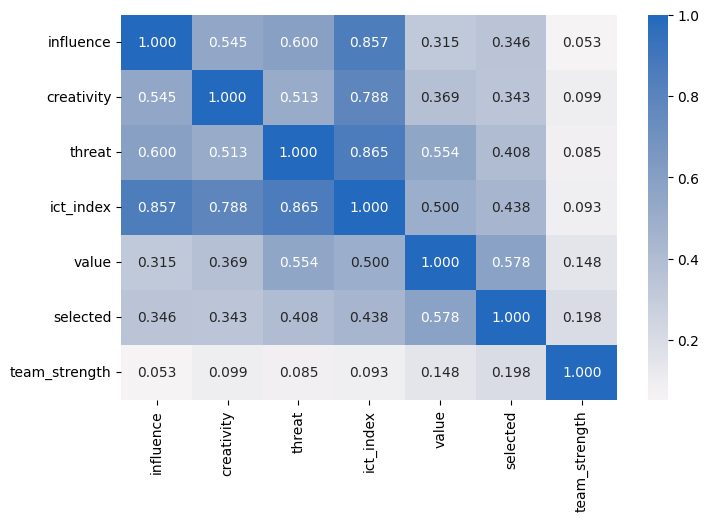

In [145]:
fpl_corr = plt.figure(figsize = [8, 5])
fpl_corr
sb.heatmap(top6clubs[fpl_metrics].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
#plt.savefig()
plt.show()

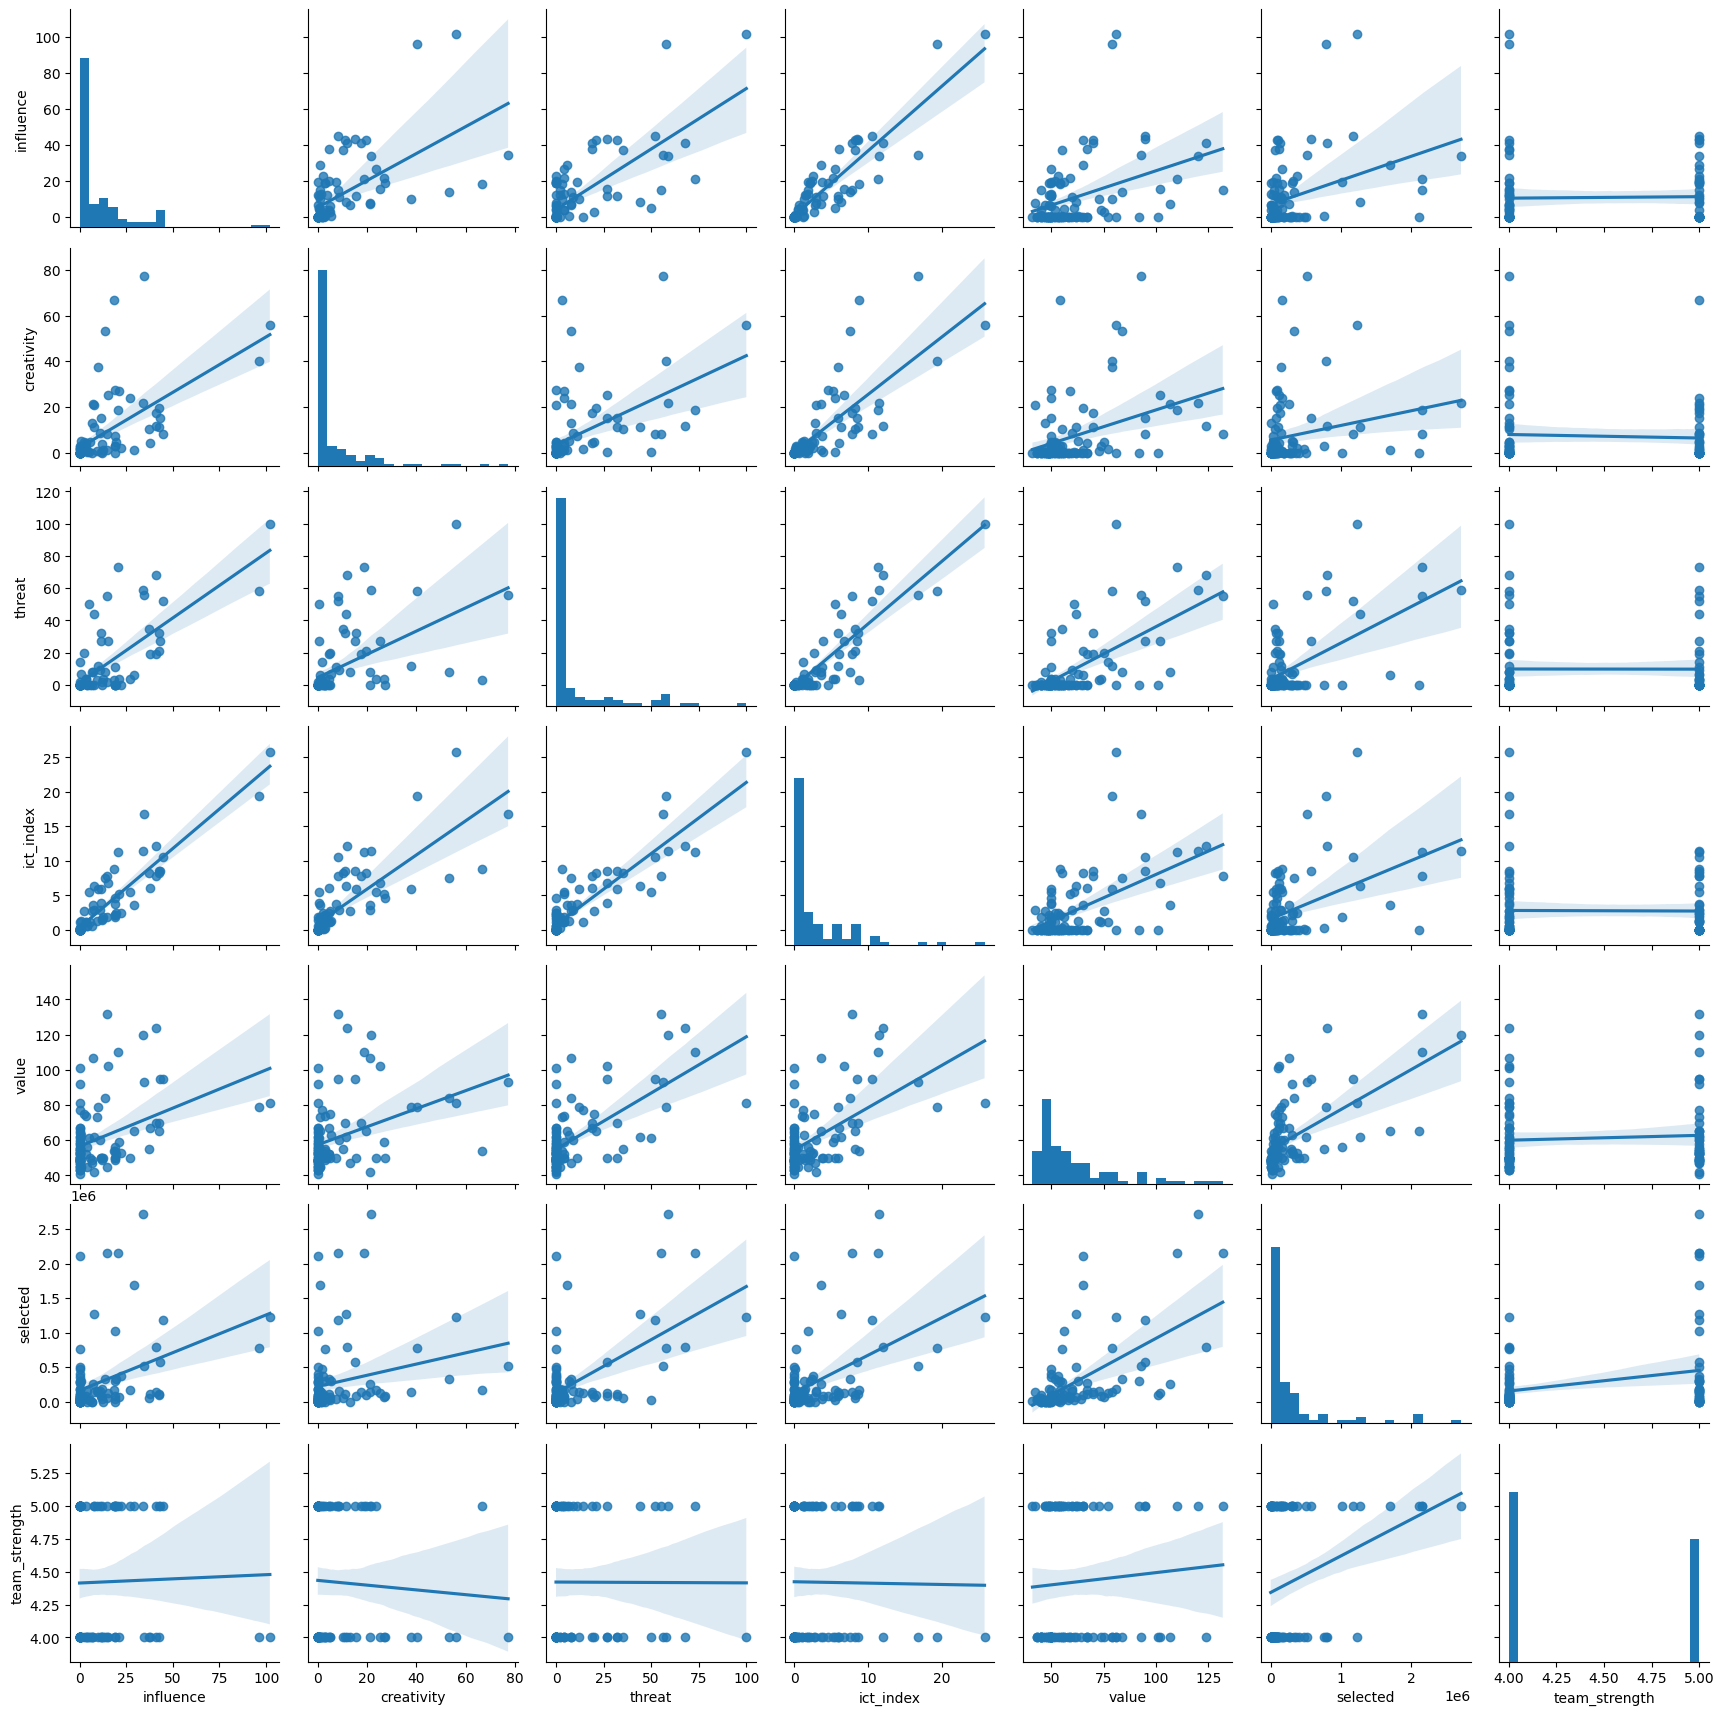

In [148]:
prem_sample = np.random.choice(top6clubs.shape[0], 100, replace = False)
prem_sample
estimate_samp = top6clubs.loc[prem_sample,:]

g = sb.PairGrid(data = estimate_samp, vars = fpl_metrics)
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(sb.regplot);

The ICT Index (which stands for Influence, Creativity & Threat index) has a strong correlation with each of the individual metrics that comprise it. 
These individual metrics are derived from a host of individual performance metrics, which include in-game actions such as crossing, key-passes and even field location of events. 

What is very interesting is the clear impact the ICT has on player valuation. At 0.5, it indicates that a players ICT is a strong factor in setting a players value. I say it this way as value is an outcome of a players performance as well as marketing. Performance is exactly what the ICT index captures.

Finally, there exists a strong connection between a players value and their gameweek selection. This is clear in that Mohamed Salah, being one of the highest valued FPL assets has in many gameweeks been selected by 3/8 or 1/4 of fpl managers. The data seems to show that, with the high valued players, you tend to get what you pay for.

With all this being said, in part two of this EDA, I will explore why the "top six" clubs have the most highly valued players. I will use the performance indicators that constitute the ICT index to identify the possible levers that drive player selection.